In [1]:
import os
import datetime
import pprint
import tempfile
import itertools
import uuid
import re
import PIL.Image as Image
import dateutil.parser
import string

from glob import glob
from typing import Dict, Text

import elasticsearch
import tensorflow as tf
import tensorflow_recommenders as tfrs
import tensorflow_hub as hub
#import tensorflow_datasets as tfds
import pandas as pd
import numpy as np
import nltk
import matplotlib.pyplot as plt
%matplotlib inline

from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.initializers import VarianceScaling
from tensorflow.errors import InvalidArgumentError, UnknownError





In [2]:
import nltk
import ssl

try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context

In [3]:
nltk.download('stopwords')
nltk.download('punkt')


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/mercef02/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/mercef02/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
# Load the data

In [4]:
MAX_JOURNEY = 50
MIN_JOURNEY = 2


def truncate_after_asset_number(url, n='8'):
    try:
        url = url[:re.search('\(|\)|\d{' + n + '}', url).end()]
        return url
    except AttributeError:
        #print(f'Warning: {url} has no asset number.')
        return None
    
def truncate_after_programme_id(url):
    p0 = url.rfind('p0')
    if p0 > 0:
        return url[:p0 + 8]
    else:
        return None


def uri_from_url(url):
    
    url = url.replace(':::', '/').replace('::', '/').replace(':', '/').replace('/av', '')

    if url.rfind('/newsround') > 0:
        url = url[url.rfind('/newsround'):]
        url = truncate_after_asset_number(url)
    elif url.rfind('/news') > 0:
        url = url[url.rfind('/news'):]
        if url.find('/localnews') > 0:
            url = truncate_after_asset_number(url, '7')
        else:
            url = truncate_after_asset_number(url)
    elif url.rfind('/sport') > 0:
        url = url[url.rfind('/sport'):]
        url = truncate_after_asset_number(url)
    elif url.rfind('/culture') > 0:
        url = url[url.rfind('/culture'):]
        url = truncate_after_asset_number(url)
    elif url.rfind('/programmes') > 0:
        url = url[url.rfind('/programmes'):]
        url = truncate_after_programme_id(url)
    elif url.rfind('/reel/video') > 0:
        url = url[url.rfind('/reel/video'):]
        url = truncate_after_programme_id(url)
    elif url.rfind('/food') > 0:
        url = url[url.rfind('/food'):]
    elif url.rfind('/ideas') > 0:
        url = url[url.rfind('/ideas'):]
        url = truncate_after_programme_id(url)
    elif url.rfind('/bbcthree') > 0:
        url = url[url.rfind('/bbcthree'):]
    else:
        #print(f'Warning: {url} has no recognised product type.')
        url = None

    return url

def load_data(d_path, stop_after_n_files=50):
    d_paths = glob(d_path)
    dateparse = lambda x: pd.to_datetime(x)
    df = []
    for i, f_path in enumerate(d_paths):
        if i == stop_after_n_files:
            break
        df.append(pd.read_csv(f_path, parse_dates=['visit_start_datetime'],  date_parser=dateparse))
    df = pd.concat(df)
    return df

def clean_data(df):
    df = df[['audience_id', 'visit_start_datetime', 'url']]
    df = df.dropna(how='any')
    df['uri'] = df.url.apply(uri_from_url)
    df = df.dropna(how='any')
    df.drop_duplicates(['uri', 'audience_id'], inplace=True)
    return df

def get_pairs(journey, min_len=MIN_JOURNEY, max_len=MAX_JOURNEY):
    if len(journey) <= max_len and len(journey) >=min_len:
        return [{"item_a":list(journey.uri)[i-1], "item_b":list(journey.uri)[i] } for i, item in enumerate(list(journey.uri)) if i>0]
    else:
        return None

def get_es_instance(es_host: str, es_port: str, es_auth=None):
    """Return an elasticsearch connection instance corresponding to the connection parameters given"""
    es_host_config = {"host": es_host, "port": es_port}
    es = elasticsearch.Elasticsearch(hosts=[es_host_config], http_auth=es_auth)
    if not es.ping():
        raise ConnectionError(f'Connection to ES failed with config: {es_host_config, es_auth}')
    return es

In [5]:
def get_item_info(asset_uri, es_client, es_index):
    query = {"query": {"match": {"assetUri": asset_uri}}}
    results = es_client.search(index=es_index, body=query)['hits']['hits']
    if len(results) == 0 or results[0]['_source']['assetUri'] != asset_uri:
        raise ValueError(f'{asset_uri} not found in elasticsearch index.')
    return results[0]

def get_data_from_es(es_client, fields, max_records, page_size, prediction_date="2020-11-02T00:00:00", max_days=90):
    p_date = dateutil.parser.parse(prediction_date)
    days = datetime.timedelta(days=max_days)
    filter_date = p_date - days
    
    num_pages = int(np.ceil(max_records / page_size))
    hits = []
    for i in range(num_pages):
        print(i)
        if i < 1:
            q = {"query": {"bool": {"must": {"range": {"lastUpdated":{"gte": filter_date.isoformat()}}}}},
                 "_source": fields,
                 "size": page_size,
                 "sort": [{"assetUri": "asc"}]}
        else:
            
            search_after = res['hits']['hits'][-1]['sort']
            q = {"query": {"bool": {"must": {"range": {"lastUpdated":{"gte": filter_date.isoformat()}}}}},
                 "_source": fields,
                 "size": page_size,
                 "sort": [{"assetUri": "asc"}],
                 "search_after": search_after}
        
        res = es_client.search(index=_es_index, body=q)
        hits = hits + res['hits']['hits']
        if len(res['hits']['hits']) == 0:
            break
            
    return hits


def print_item(query_uri, es_client, es_index):
    try:
        meta = get_item_info(query_uri, es_client, es_index)
        summary = meta["_source"]["summary"]
    except ValueError:
        summary = "NA"
            
    print(f'{query_uri} \n {summary}')


def generate_model_recs(query_uri, nn_engine, uri2id, id2uri, uri2vector, es_client, es_index, k):
    query_vector = uri2vector[query_uri]
    rec_ids = nn_engine.get_nns_by_vector(query_vector, k)
    rec_uris = [id2uri[r] for r in rec_ids]
    print('Generating recommendations for:')
    print_item(query_uri, es_client, es_index)
    print('-------------------')
    print('-------------------')        
    return rec_uris


def plot_metric(history, metric, validation_freq=1):
    num_validation_runs = len(one_layer_history.history[f"val_{metric}"])
    num_train_runs = len(one_layer_history.history[metric])
    epochs = [(x + 1)* validation_freq for x in range(num_validation_runs)]
    train_epochs = np.arange(1, num_train_runs+1)

    plt.plot(epochs, one_layer_history.history[f"val_{metric}"], label="validation")
    plt.plot(train_epochs, one_layer_history.history[metric], label="train")
    plt.title(f"{metric} vs epoch")
    plt.xlabel("epoch")
    plt.ylabel(metric);
    plt.legend()
    
    


In [6]:
class ItemEmbeddingModel(tf.keras.Model):

  def __init__(self, features=['item_id', 'body'], feature_dims=[32, 32], unique_item_ids=None, item_body_lookup=None, item_tags_lookup=None,
              item_category_lookup=None, item_image_lookup=None, image_embedding_lookup_table=None):
    super().__init__()
    
    self.features = features
    self.IMAGE_SHAPE = (96, 96)
    
    for feature, embedding_dim in zip(self.features, feature_dims):
        # Define model for item_id embedding generation
        if 'item_id' == feature: 
            unique_item_ids
            self.item_id_embedding = tf.keras.Sequential([
                tf.keras.layers.experimental.preprocessing.StringLookup(
                    vocabulary=unique_item_ids, mask_token=None, name="item_id_string_lookup_layer"),
                tf.keras.layers.Embedding(input_dim=len(unique_item_ids) + 1, output_dim=embedding_dim, name="item_id_embedding_layer"),
            ], name='sequential_id_embedding')

    
        # Define model for body embedding generation
        if 'body' == feature:
            max_tokens = 10_000
            self.item_body_lookup_table = item_body_lookup
            self.body_embedding = tf.keras.Sequential([
              tf.keras.layers.experimental.preprocessing.TextVectorization(max_tokens=max_tokens, name="body_text_vectorisation_layer"),
              tf.keras.layers.Embedding(input_dim=max_tokens, output_dim=embedding_dim, mask_zero=True, name="body_embedding_layer"),
              tf.keras.layers.GlobalAveragePooling1D(name="body_global_averaging_pooling_layer"),
            ], name='sequential_body_embedding')

            # Define model for tags embedding generation
        if 'tags' == feature:
            max_tokens = 10_000
            self.item_tags_lookup_table = item_tags_lookup
            self.tags_embedding = tf.keras.Sequential([
              tf.keras.layers.experimental.preprocessing.TextVectorization(max_tokens=max_tokens, name="tags_text_vectorisation_layer"),
              tf.keras.layers.Embedding(input_dim=max_tokens, output_dim=embedding_dim, mask_zero=True, name="tags_embedding_layer"),
              tf.keras.layers.GlobalAveragePooling1D(name="tags_global_averaging_pooling_layer"),
            ], name='sequential_tags_embedding')

        if 'category'== feature:
            _, values = item_category_lookup.export()
            self.item_category_lookup_table = item_category_lookup
            unique_categories = np.unique(values.numpy())
            self.category_embedding = tf.keras.Sequential([
            tf.keras.layers.experimental.preprocessing.StringLookup(
                    vocabulary=unique_categories, mask_token=None, name="category_string_lookup_layer"),
            tf.keras.layers.Embedding(input_dim=len(unique_categories) + 1, output_dim=embedding_dim, name="category_embedding_layer"),
            ], name='sequential_category_embedding')
            
        if 'image_embedding' == feature:
            self.image_embedding_lookup_table = image_embedding_lookup_table
            self.image_embedding_model = tf.keras.Sequential([tf.Input
            
        
        if isinstance(embedding_dim, dict):
            if embedding_dim.get('format') == 'image':
                #IMAGE_MODEL_LINK ="https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"
                #IMAGE_MODEL_LINK = "https://tfhub.dev/google/imagenet/inception_v3/feature_vector/4"
                model_link = embedding_dim.get('link', 'https://tfhub.dev/google/imagenet/mobilenet_v2_100_96/feature_vector/4')
                print(f"Using pretrained IMAGE model: {model_link}")
                self.item_image_lookup_table = item_image_lookup 
                self.image_embedding = tf.keras.Sequential([
                    hub.KerasLayer(model_link, input_shape=self.IMAGE_SHAPE+(3,),trainable=False),
                   # tf.keras.layers.Embedding(input_dim=len(unique_item_ids) + 1, output_dim=embedding_dim, name="image_embedding_layer"),
                   #  tf.keras.layers.GlobalAveragePooling1D(name="image_global_averaging_pooling_layer")
                    ])

            if embedding_dim.get('format') == 'text':
                model_link = embedding_dim.get('link', 'https://tfhub.dev/google/nnlm-en-dim50/2')
                print(f"Using pretrained TEXT model: {model_link}")
                self.item_body_lookup_table = item_body_lookup
                self.text_model_embedding = tf.keras.Sequential([
                    hub.KerasLayer(model_link, input_shape=[], dtype=tf.string, trainable=False)
                    #tf.keras.layers.Embedding(input_dim=MODEL_DIM, output_dim=embedding_dim, mask_zero=True, name="text_model_embedding_layer")
                    # tf.keras.layers.GlobalAveragePooling1D(name="text_model_global_averaging_pooling_layer")
                    ])

             
  def read_image(self, file_url):
    file_url_string = file_url.numpy().decode()
    if file_url_string == "nill":
        return np.zeros(shape=(1, self.IMAGE_SHAPE[0], self.IMAGE_SHAPE[1],3))+128
    try:
        im = tf.keras.utils.get_file(file_url_string.replace('/','_'), file_url_string)
        im = Image.open(im).resize(self.IMAGE_SHAPE)
        im = np.array(im)/255.0
        try:
            im = im[:,:,:3]
        except (IndexError, UnknownError): 
            im = np.repeat(im[:, :, np.newaxis], 3, axis=2)
        return im[np.newaxis, ...]
    except:
        return np.zeros(shape=(1, self.IMAGE_SHAPE[0], self.IMAGE_SHAPE[1],3))+128

  def call(self, inputs):
    
    feature_embeddings = []

    if 'item_id' in self.features:
        feature_embeddings.append(self.item_id_embedding(inputs))
    
    if 'body' in self.features:
        body = self.item_body_lookup_table.lookup(inputs)
        feature_embeddings.append(self.body_embedding(body))
        
    if 'tags' in self.features:
        tags = self.item_tags_lookup_table.lookup(inputs)
        feature_embeddings.append(self.tags_embedding(tags))
        
    if 'category' in self.features:
        category = self.item_category_lookup_table.lookup(inputs)
        feature_embeddings.append(self.category_embedding(category))
    
    if 'image_embedding' in self.features:
        image_embedding = self.image_embedding_lookup_table.lookup(inputs)
        feature_embeddings.append(image_embedding)
        
    if 'image' in self.features:
        image_url = self.item_image_lookup_table.lookup(inputs)
        image = tf.map_fn(fn=lambda s:tf.py_function(self.read_image, inp=[s], Tout=tf.float64), elems=image_url, fn_output_signature=tf.float64)
        image = tf.cast(tf.squeeze(image), tf.float32)
        feature_embeddings.append(self.image_embedding(image))
                
    if 'text_model' in self.features:
        text = self.item_body_lookup_table.lookup(inputs)
        feature_embeddings.append(self.text_model_embedding(text))
        
    return tf.concat(feature_embeddings, axis=1)


class DeepItemModel(tf.keras.Model):
    
  def __init__(self, features=['item_id', 'body'], feature_dims=[32, 32], unique_item_ids=None, item_body_lookup=None,
               item_tags_lookup=None, item_category_lookup=None, item_image_lookup=None, image_embedding_lookup_table=None,
               layer_sizes=[32]):
    """Model for encoding items.

    Args:
      layer_sizes:
        A list of integers where the i-th entry represents the number of units
        the i-th layer contains.
    """
    super().__init__()

    self.embedding_model = ItemEmbeddingModel(features=features,
                                              feature_dims=feature_dims,
                                              unique_item_ids=unique_item_ids,
                                              item_body_lookup=item_body_lookup,
                                              item_tags_lookup=item_tags_lookup,
                                              item_category_lookup=item_category_lookup,
                                              item_image_lookup=item_image_lookup,
                                              image_embedding_lookup_table=image_embedding_lookup_table)
    
     # Then construct the layers.
    self.dense_layers = tf.keras.Sequential(name='sequential_deep')

     # Use the ReLU activation for all but the last layer.
    for i, layer_size in enumerate(layer_sizes[:-1]):
        self.dense_layers.add(tf.keras.layers.Dense(layer_size,
                                                    activation="relu",
                                                    kernel_initializer=VarianceScaling(),
                                                    bias_initializer=VarianceScaling(),
                                                    name=f"dense_layer_{i+1}_{str(uuid.uuid4())}"))
#         Batch normalization after the first layer
#         if i == 0:
#             self.dense_layers.add(tf.keras.layers.BatchNormalization())

    # No activation for the last layer.
    for layer_size in layer_sizes[-1:]:
        self.dense_layers.add(tf.keras.layers.Dense(layer_size,
                                                    kernel_initializer=VarianceScaling(),
                                                    bias_initializer=VarianceScaling(),
                                                    name=f"dense_layer_{len(layer_sizes)}_{str(uuid.uuid4())}"))
    
  def call(self, inputs):
    feature_embedding = self.embedding_model(inputs)
    return self.dense_layers(feature_embedding)
    
    
class ItemSimilarityModel(tfrs.Model):
  # We derive from a custom base class to help reduce boilerplate. Under the hood,
  # these are still plain Keras Models.

  def __init__(self, test_candidate_ids, features=['item_id', 'body'],
               feature_dims=[32, 32],
               unique_item_ids=None,
               item_body_lookup=None,
               item_tags_lookup=None,
               item_category_lookup=None,
               item_image_lookup=None,
               image_embedding_lookup_table=None,
               layer_sizes=None,
               pretrained_text_model=None,
               pretrained_image_model=None,
               compute_metrics=True):
    super().__init__()
    self.compute_metrics = compute_metrics
    self.pretrained_text_model = pretrained_text_model
    self.pretrained_image_model = pretrained_image_model
    if layer_sizes:
        self.item_model = DeepItemModel(features=features,
                                        unique_item_ids=unique_item_ids,
                                        feature_dims=feature_dims,
                                        item_body_lookup=item_body_lookup,
                                        item_tags_lookup=item_tags_lookup,
                                        item_category_lookup=item_category_lookup,
                                        item_image_lookup=item_image_lookup,
                                        image_embedding_lookup_table=image_embedding_lookup_table,
                                        layer_sizes=layer_sizes)
    else:        
        self.item_model = ItemEmbeddingModel(features=features,
                                             feature_dims=feature_dims,
                                             unique_item_ids=unique_item_ids,
                                             item_body_lookup=item_body_lookup,
                                             item_tags_lookup=item_tags_lookup,
                                             item_category_lookup=item_category_lookup,
                                             item_image_lookup=item_image_lookup,
                                             image_embedding_lookup_table=image_embedding_lookup_table)
    
    #if isinstance(test_candidate_ids, np.ndarray):
    test_candidate_ids = tf.data.Dataset.from_tensor_slices(test_candidate_ids)
        
    self.task = tfrs.tasks.Retrieval(loss=tf.keras.losses.CategoricalCrossentropy(),
            metrics=tfrs.metrics.FactorizedTopK(candidates=test_candidate_ids.batch(512).map(self.item_model)))

  def compute_loss(self, raw_features: Dict[Text, tf.Tensor], training=False) -> tf.Tensor:
    # Define how the loss is computed.

    item_a_embeddings = self.item_model(raw_features["item_a"])
    item_b_embeddings = self.item_model(raw_features["item_b"])

    return self.task(query_embeddings=item_a_embeddings,
                     candidate_embeddings=item_b_embeddings, 
                    # candidate_ids=raw_features["item_b"],
                    compute_metrics=self.compute_metrics)

In [7]:
#Image research

# IMAGE_SHAPE = (224, 224)
# def read_image(file_url):
#     file_url_string = file_url.numpy().decode()
#     if file_url_string == "nill":
#         return np.zeros(shape=(1, IMAGE_SHAPE[0], IMAGE_SHAPE[1],3))+0.5
#     try:
#         im = tf.keras.utils.get_file(file_url_string.replace('/','_'), file_url_string)
#         im = Image.open(im).resize(IMAGE_SHAPE)
#         im = np.array(im)/255.0
#         return im[np.newaxis, ...]
#     except (InvalidArgumentError, ValueError):
#         return np.zeros(shape=(1, IMAGE_SHAPE[0], IMAGE_SHAPE[1],3))+0.5

# image_urls = thumbnail_lookup_table.lookup(tf.constant(['/sport/football/39201743', '/news/world-middle-east-40443989', 'vdsvdc']))

# images = tf.map_fn(fn=lambda s: read_image(s), elems=image_urls, fn_output_signature=tf.float64)
# images = tf.squeeze(images)

In [55]:
nltk_stopwords = nltk.corpus.stopwords.words('english')

def clean_text(text):
    table = str.maketrans(dict.fromkeys(string.punctuation)) 
    text = text.translate(table)
    tokens = nltk.tokenize.word_tokenize(text)
    tokens = [token for token in tokens if not token in nltk_stopwords]
    return ' '.join(tokens)

def get_tf_lookup_table_for_property(es_data_hits, field, clean=False):
    if clean:
        data_dict = {f['sort'][0]:clean_text(f['_source'][field]) for f in es_data_hits if field in f['_source']}
    else:
        data_dict = {f['sort'][0]:f['_source'][field] for f in es_data_hits if field in f['_source']}
    
    initializer = tf.lookup.KeyValueTensorInitializer(keys=list(data_dict.keys()), values=list(data_dict.values()), key_dtype=tf.string, value_dtype=tf.string)
    lookup_table = tf.lookup.StaticHashTable(initializer, default_value="nill")
    print(f"Tensorflow lookup table created for {field} with {len(data_dict.keys())} entries.")
    unique_values = np.array(list(set(data_dict.values())))
    return lookup_table,  unique_values


def get_tf_lookup_for_dict(data_dict):
    vec_shape = list(data_dict.values())[0].shape
    lookup_table = tf.lookup.experimental.DenseHashTable(key_dtype=tf.string, value_dtype=tf.float32, empty_key="<EMPTY_SENTINEL>", deleted_key="<DELETE_SENTINEL>", default_value=tf.convert_to_tensor(np.zeros(shape=vec_shape), dtype=tf.float32))
    lookup_table.insert(list(im_embeddings.keys()), list(im_embeddings.values()))
    print(f"Tensorflow lookup table created for vector dim={vec_shape} with {len(data_dict.keys())} entries.")
    return lookup_table

def filter_logs(logs, min_date, max_date, min_mentions):
    print(f'Original interactions: {len(logs)}')
    logs = logs[logs.visit_start_datetime.between(min_date, max_date)]
    print(f'Date filtered interactions: {len(logs)}')
        
    logs = logs.groupby('url').filter(lambda x: len(x) >= min_mentions)
    print(f'Minimum mention filtered interactions  : {len(logs)}')
    return logs
        
    
def read_image(file_url, image_shape):
    file_url_string = file_url.numpy().decode()

    if file_url_string == "nill":
        return np.zeros(shape=(1, image_shape[0], image_shape[1],3))+128
    
    if file_url_string.startswith('http') is False:
        file_url_string = 'https://' + file_url_string
        
    try:
        im = tf.keras.utils.get_file(file_url_string.replace('/','_'), file_url_string)
        im = Image.open(im).resize(image_shape)
        im = np.array(im)/255.0
        try:
            im = im[:,:,:3]
        except (IndexError, UnknownError): 
            im = np.repeat(im[:, :, np.newaxis], 3, axis=2)
        return im[np.newaxis, ...]
    except:
        return np.zeros(shape=(1, image_shape[0], image_shape[1],3))+128
    

#     return tf.cast(im[np.newaxis, ...], tf.float64)
#     
#     return 
# txt = """A record 32 million Latinos were eligible to vote in the 2020 election, making them 
# the largest minority bloc of voters in the country. Although they historically lean Democrat,
# their support for the Republican party has been increasing."""


#image_urls = thumbnail_lookup_table.lookup(tf.constant(['/sport/football/39201743', '/news/world-middle-east-40443989']))

# #dataset = tf.data.Dataset.from_tensor_slices(image_urls)
# print(image_urls)
# file_name = tf.compat.v1.placeholder(tf.string)
# images = tf.map_fn(fn=tf.py_function(read_image, inp=[file_name], Tout=tf.float64), elems=image_urls, fn_output_signature=tf.float64)

# #feature_embeddings.append(self.image_embedding(images))

In [10]:
# inp = body_lookup_table.lookup(tf.convert_to_tensor(['/news/uk-england-nottinghamshire-54731548', '/news/election-us-2020-54754797']))
# TEXT_MODEL_LINK = 'https://tfhub.dev/tensorflow/albert_en_large/2'
# #TEXT_MODEL_LINK = 'https://tfhub.dev/google/nnlm-en-dim50/2'
# TEXT_MODEL_LINK = 'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-128_A-2/1'

# text_model_embedding = tf.keras.Sequential([
#     hub.KerasLayer(TEXT_MODEL_LINK,input_shape=[],
#                 dtype=tf.string, trainable=False),
# #    tf.keras.layers.Embedding(input_dim=50, output_dim=embedding_dim, name="text_model_embedding_layer"),
# #    tf.keras.layers.GlobalAveragePooling1D(name="text_model_global_averaging_pooling_layer")
#     ])
# text_model_embedding(inp)


## Get metadata from ES for all items

Load the raw video text into a tesorflow lookup table.

In [23]:
_es_index = 'sfv_02112020'
_es_host = 'localhost'
_es_port = '9200'
es = get_es_instance(es_host=_es_host, es_port=_es_port)
prediction_time = "2020-11-02T00:00:00"
max_age_days = 90

In [29]:
features = ["combinedBodySummaryHeadline","tagsText", "articleCategoryName", "thumbnailUrl"]
hits = get_data_from_es(es, features, 30000, 5000, prediction_time, max_age_days)


0
1
2


In [58]:
body_lookup_table, _ = get_tf_lookup_table_for_property(hits, "combinedBodySummaryHeadline", clean=True)
tags_lookup_table, _ = get_tf_lookup_table_for_property(hits, "tagsText")
category_lookup_table, unique_categories = get_tf_lookup_table_for_property(hits, "articleCategoryName")
thumbnail_lookup_table, _ = get_tf_lookup_table_for_property(hits, "thumbnailUrl")
im_vec_lookup_table = get_tf_lookup_for_dict(im_embeddings)
unique_item_ids = [hit['sort'][0] for hit in hits]
print(f"Unique item ids: {len(unique_item_ids)}")




Tensorflow lookup table created for combinedBodySummaryHeadline with 5060 entries.
Tensorflow lookup table created for tagsText with 3544 entries.
Tensorflow lookup table created for articleCategoryName with 4527 entries.
Tensorflow lookup table created for thumbnailUrl with 5060 entries.
Tensorflow lookup table created for vector dim=(2048,) with 5060 entries.
Unique item ids: 5060


### Generate metadata embeddings

In [56]:
model_link = 'https://tfhub.dev/google/imagenet/resnet_v2_152/feature_vector/4'
model = tf.keras.Sequential([
    hub.KerasLayer(model_link,
                   trainable=False)])
model.build([None, 224, 224, 3])

IMAGE_SHAPE = (224,224)
im_embeddings = {}
for i, uri in enumerate(unique_item_ids):
    if i % 10 == 0:
        print(f"Downloading image {i}")
    url = thumbnail_lookup_table.lookup(tf.constant(str.encode(uri)))
    image = read_image(url, IMAGE_SHAPE)
    embedding = model(image)
    if isinstance(embedding.numpy()[0][0], np.float32):
        
        im_embeddings[uri] = embedding.numpy()[0]
    

import pickle

with open('resnet_embeddings.pk', 'wb') as f:
    pickle.dump(im_embeddings, f)

16384/13440 [====================================] - 0s 2us/step


24576/17924 [=========================================] - 0s 1us/step


16384/13790 [===================================] - 0s 2us/step


16384/12295 [=======================================] - 0s 2us/step


16384/10632 [==============================================] - 0s 0us/step


24576/22756 [================================] - 0s 1us/step


16384/13742 [===================================] - 0s 2us/step


16384/14332 [==================================] - 0s 2us/step


24576/20618 [===================================] - 0s 1us/step


16384/11705 [=========================================] - 0s 2us/step


8192/7437 [=================================] - 0s 0us/step


8192/6807 [====================================] - 0s 0us/step


16384/14044 [==================================] - 0s 2us/step


8192/6742 [====================================] - 0s 0us/step


16384/11797 [=========================================] - 0s 2us/step


16384/11545 [==========================================] - 0s 2us/step


8192/6896 [===================================] - 0s 0us/step


8192/6504 [=====================================] - 0s 0us/step


24576/20985 [===================================] - 0s 1us/step


16384/15765 [===============================] - 0s 2us/step


24576/17348 [==========================================] - 0s 2us/step


16384/10949 [============================================] - 0s 2us/step


8192/7156 [==================================] - 0s 0us/step


24576/19766 [=====================================] - 0s 1us/step


24576/22191 [=================================] - 0s 1us/step


16384/11289 [===========================================] - 0s 3us/step


16384/11564 [==========================================] - 0s 2us/step


16384/11303 [===========================================] - 0s 2us/step


24576/20305 [====================================] - 0s 1us/step


16384/13383 [====================================] - 0s 3us/step


16384/12009 [========================================] - 0s 2us/step


16384/10060 [================================================] - 0s 0us/step


16384/9768 [==================================================] - 0s 0us/step


16384/14019 [===================================] - 0s 3us/step


24576/18758 [=======================================] - 0s 1us/step


16384/10582 [==============================================] - 0s 4us/step


16384/13754 [===================================] - 0s 2us/step


16384/11042 [============================================] - 0s 2us/step


16384/11015 [============================================] - 0s 2us/step


16384/15267 [================================] - 0s 2us/step


16384/12047 [========================================] - 0s 2us/step


8192/7288 [=================================] - 0s 0us/step


16384/15883 [==============================] - 0s 2us/step


24576/18090 [========================================] - 0s 1us/step


16384/13106 [=====================================] - 0s 2us/step


16384/15741 [===============================] - 0s 2us/step


16384/11455 [==========================================] - 0s 2us/step


24576/23873 [==============================] - 0s 1us/step


16384/10587 [==============================================] - 0s 0us/step


8192/6129 [========================================] - 0s 0us/step


24576/17716 [=========================================] - 0s 1us/step


16384/8473 [==========================================================] - 0s 0us/step


16384/10864 [=============================================] - 0s 2us/step


16384/12213 [========================================] - 0s 2us/step


16384/14764 [=================================] - 0s 2us/step


16384/15172 [================================] - 0s 2us/step


16384/10284 [===============================================] - 0s 0us/step


24576/19766 [=====================================] - 0s 1us/step


16384/15931 [==============================] - 0s 5us/step


24576/23563 [===============================] - 0s 1us/step


16384/8324 [===========================================================] - 0s 0us/step


16384/12857 [======================================] - 0s 2us/step


16384/14101 [==================================] - 0s 2us/step


24576/18430 [========================================] - 0s 1us/step


16384/15832 [===============================] - 0s 2us/step


24576/19703 [=====================================] - 0s 1us/step


16384/13664 [===================================] - 0s 2us/step


16384/11654 [==========================================] - 0s 2us/step


16384/15615 [===============================] - 0s 2us/step


16384/14874 [=================================] - 0s 2us/step


16384/9144 [=====================================================] - 0s 0us/step


8192/5956 [=========================================] - 0s 0us/step


98304/95504 [==============================] - 0s 2us/step


24576/19914 [=====================================] - 0s 1us/step


24576/19425 [=====================================] - 0s 1us/step


16384/12717 [======================================] - 0s 2us/step


24576/18318 [========================================] - 0s 1us/step


24576/16784 [===========================================] - 0s 1us/step


16384/12912 [======================================] - 0s 2us/step


16384/15367 [===============================] - 0s 2us/step


16384/10307 [===============================================] - 0s 0us/step


16384/11741 [=========================================] - 0s 2us/step


16384/16078 [==============================] - 0s 2us/step


16384/12235 [========================================] - 0s 2us/step


16384/12645 [======================================] - 0s 2us/step


24576/18663 [=======================================] - 0s 1us/step


16384/10507 [==============================================] - 0s 0us/step


16384/10710 [=============================================] - 0s 2us/step


24576/18316 [========================================] - 0s 1us/step


16384/12171 [========================================] - 0s 2us/step


16384/10373 [===============================================] - 0s 0us/step


In [51]:
file_url = url
image_shape = (224,224)
file_url_string = file_url.numpy().decode()
if file_url_string == "nill":
    np.zeros(shape=(1, image_shape[0], image_shape[1],3))+128
try:
    im = tf.keras.utils.get_file(file_url_string.replace('/','_'), 'https://'+file_url_string)
    im = Image.open(im).resize(image_shape)
    im = np.array(im)/255.0
    try:
        im = im[:,:,:3]
    except (IndexError, UnknownError): 
        im = np.repeat(im[:, :, np.newaxis], 3, axis=2)
    imout = im[np.newaxis, ...]
except:
    imout =np.zeros(shape=(1, image_shape[0], image_shape[1],3))+128

16384/10373 [===============================================] - 0s 0us/step


In [49]:
file_url = url
image_shape = (224,224)
file_url_string = file_url.numpy().decode()
im = tf.keras.utils.get_file(file_url_string.replace('/','_'), file_url_string)
im = Image.open(im).resize(image_shape)
im = np.array(im)/255.0

ValueError: unknown url type: 'ichef.bbci.co.uk/images/ic/320x180/p08n1vp4.jpg'

In [52]:
imout


array([[[[0.29411765, 0.26666667, 0.17254902],
         [0.31372549, 0.2745098 , 0.18823529],
         [0.3254902 , 0.28627451, 0.18823529],
         ...,
         [0.36078431, 0.30588235, 0.15294118],
         [0.36862745, 0.31764706, 0.17254902],
         [0.37647059, 0.32941176, 0.18823529]],

        [[0.29803922, 0.27058824, 0.17647059],
         [0.31372549, 0.27843137, 0.18823529],
         [0.3254902 , 0.28627451, 0.18823529],
         ...,
         [0.35686275, 0.30196078, 0.14901961],
         [0.36470588, 0.31372549, 0.16862745],
         [0.37254902, 0.3254902 , 0.18431373]],

        [[0.29803922, 0.27058824, 0.18039216],
         [0.31372549, 0.27843137, 0.18823529],
         [0.3254902 , 0.28627451, 0.18823529],
         ...,
         [0.35686275, 0.30196078, 0.14901961],
         [0.36078431, 0.30980392, 0.16470588],
         [0.36862745, 0.32156863, 0.18431373]],

        ...,

        [[0.77647059, 0.86666667, 0.9372549 ],
         [0.77647059, 0.86666667, 0.9372549 ]

In [303]:
tf.convert_to_tensor(np.zeros(shape=(1280,)), dtype=tf.float32)

<tf.Tensor: shape=(1280,), dtype=float32, numpy=array([0., 0., 0., ..., 0., 0., 0.], dtype=float32)>

In [ ]:
def parse_function(filename):
    image_string = tf.io.read_file(filename)
    image_decoded = tf.image.decode_image(image_string)
    image = tf.cast(image_decoded, tf.float32)
    return image

def read_image(file_name):
    IMAGE_SHAPE = (64, 64)
    im = tf.keras.utils.get_file(file_name.replace('/', '_'),'http://news.bbcimg.co.uk/media/images/67102000/jpg/_67102613_67102612.jpg')
    im = Image.open(grace_hopper).resize(IMAGE_SHAPE)
    im = np.array(im)/255.0
    return im[np.newaxis, ...]

## Load the user data
    Load the vocabulary of the of item IDs into a tensorflow dataset.

In [12]:
DATA_PATH = '/Users/mercef02/Projects/datasets_models/sfv_user_user_zoom_20201026_20201102/sfv_user*' #'/Users/mercef02/Projects/datasets/sfv_user_week_compact/*.csv'
logs = load_data(d_path=DATA_PATH, stop_after_n_files=3)
logs = clean_data(logs)


### Training data

In [13]:
min_date = pd.to_datetime('2020-10-31T00:00:00')
max_date = pd.to_datetime('2020-11-01T11:59:59')
min_mentions = 5
train_logs = filter_logs(logs, min_date, max_date, min_mentions)
train_logs = train_logs[np.isin(train_logs['uri'], unique_item_ids)]
print(f"Content filtered interactions: {len(train_logs)}")


Original interactions: 7052134
Date filtered interactions: 1772802
Minimum mention filtered interactions  : 1690846


NameError: name 'unique_item_ids' is not defined

In [17]:
train_logs = train_logs[np.isin(train_logs['uri'], unique_item_ids)]
print(f"Content filtered interactions: {len(train_logs)}")

Content filtered interactions: 1241746



### Generate item pairs 


In [18]:
train_logs = train_logs.sort_values(by='visit_start_datetime').groupby('audience_id').apply(lambda x:  get_pairs(x))
train_logs.dropna(inplace=True)

train_all_pairs = [a for b in train_logs.tolist() for a in b]
print(f"Total number of item pairs: {len(train_all_pairs)}")
train_all_pairs = dict(pd.DataFrame(train_all_pairs))
train_logs_tf = tf.data.Dataset.from_tensor_slices(train_all_pairs)

Total number of item pairs: 242245


In [19]:
all_pairs_pd = pd.DataFrame([a for b in train_logs.tolist() for a in b])
all_pairs_pd['shingled'] = all_pairs_pd['item_a'] + '_' + all_pairs_pd['item_b']
vc = all_pairs_pd.shingled.value_counts()
all_pairs_pd.head()

,item_a,item_b,shingled
0,/news/world-us-canada-54754415,/news/election-us-2020-54757538,/news/world-us-canada-54754415_/news/election-...
1,/news/world-us-canada-54745441,/news/world-europe-54764386,/news/world-us-canada-54745441_/news/world-eur...
2,/sport/rugby-union/54763014,/sport/rugby-union/54765801,/sport/rugby-union/54763014_/sport/rugby-union...
3,/sport/boxing/54742612,/news/uk-england-nottinghamshire-54731548,/sport/boxing/54742612_/news/uk-england-nottin...
4,/news/uk-54761037,/news/world-europe-54764386,/news/uk-54761037_/news/world-europe-54764386


<AxesSubplot:>

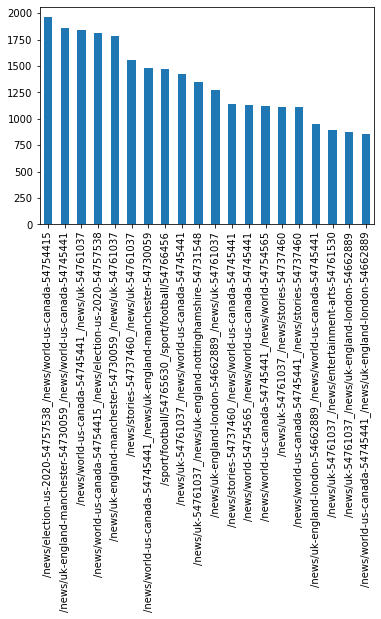

In [20]:
vc.head(20).plot(kind='bar')

### Holdout data

In [21]:

min_date = pd.to_datetime('2020-11-01T12:00:00')
max_date = pd.to_datetime('2020-11-02T00:00:00')
min_mentions = 5
holdout_logs = filter_logs(logs, min_date, max_date, min_mentions)
holdout_logs = holdout_logs[np.isin(holdout_logs['uri'], unique_item_ids)]
print(f"Content filtered interactions: {len(holdout_logs)}")
holdout_logs = holdout_logs.sort_values(by='visit_start_datetime').groupby('audience_id').apply(lambda x:  get_pairs(x))
holdout_logs.dropna(inplace=True)

holdout_all_pairs = [a for b in holdout_logs.tolist() for a in b]
print(f"Total number of holdout item pairs: {len(holdout_all_pairs)}")
holdout_all_pairs = dict(pd.DataFrame(holdout_all_pairs))
holdout_logs_tf = tf.data.Dataset.from_tensor_slices(holdout_all_pairs)



Original interactions: 7052134
Date filtered interactions: 746980
Minimum mention filtered interactions  : 698555
Content filtered interactions: 505485
Total number of holdout item pairs: 70631


## Train/Test Split

In [62]:
tf.random.set_seed(42)
training_shuffled = train_logs_tf.shuffle(buffer_size=100_000, seed=42, reshuffle_each_iteration=False)
train_pc = 0.9
test_pc = 0.1
sfv_train = training_shuffled.take(np.floor(len(training_shuffled)*train_pc))
sfv_val = training_shuffled.skip(np.floor(len(training_shuffled)*train_pc))
print(f'Number of train pairs: {len(sfv_train)}')
print(f'Number of test pairs: {len(sfv_val)}')


Number of train pairs: 218020
Number of test pairs: 24225


## Training

In [77]:

num_epochs = 2
lr = 0.01
cached_train = sfv_train.batch(128).cache()
cached_test = sfv_val.batch(128).cache()
model_one_layer = ItemSimilarityModel(test_candidate_ids=unique_item_ids,
                                      features=['body', 'category'],
                                      feature_dims=[100, 64],
                                      unique_item_ids=unique_item_ids,
                                      item_body_lookup=body_lookup_table,
                                      item_tags_lookup=tags_lookup_table,
                                      item_category_lookup=category_lookup_table,
                                      item_image_lookup=thumbnail_lookup_table,
                                      layer_sizes=[64],
                                      pretrained_text_model=model_link)
model_one_layer.compile(optimizer=tf.keras.optimizers.Adagrad(lr))

one_layer_history = model_one_layer.fit(
    cached_train,
    validation_data=cached_test,
    validation_freq=1,
    epochs=num_epochs,
    verbose=1)
#    callbacks=[tensorboard_callback])

print(f'Train accuracy: {one_layer_history.history["factorized_top_k/top_100_categorical_accuracy"][-1]}')   
print(f'Validation accuracy: {one_layer_history.history["val_factorized_top_k/top_100_categorical_accuracy"][-1]}')

metrics = one_layer_history.evaluate(holdout_logs_tf.batch(128).cache())

Epoch 1/2


1704/1704 [==============================] - 898s 527ms/step - factorized_top_k/top_1_categorical_accuracy: 0.1047 - factorized_top_k/top_5_categorical_accuracy: 0.1047 - factorized_top_k/top_10_categorical_accuracy: 0.1047 - factorized_top_k/top_50_categorical_accuracy: 0.1199 - factorized_top_k/top_100_categorical_accuracy: 0.1304 - loss: 7.0060 - regularization_loss: 0.0000e+00 - total_loss: 7.0060 - val_factorized_top_k/top_1_categorical_accuracy: 0.0546 - val_factorized_top_k/top_5_categorical_accuracy: 0.0601 - val_factorized_top_k/top_10_categorical_accuracy: 0.0611 - val_factorized_top_k/top_50_categorical_accuracy: 0.1153 - val_factorized_top_k/top_100_categorical_accuracy: 0.1766 - val_loss: 7.9806 - val_regularization_loss: 0.0000e+00 - val_total_loss: 7.9806
Epoch 2/2
1704/1704 [==============================] - 972s 570ms/step - factorized_top_k/top_1_categorical_accuracy: 0.1180 - factorized_top_k/top_5_categorical_accuracy: 0.1180 - factorized_top_k/top_10_categorical_ac

AttributeError: 'History' object has no attribute 'evaluate'

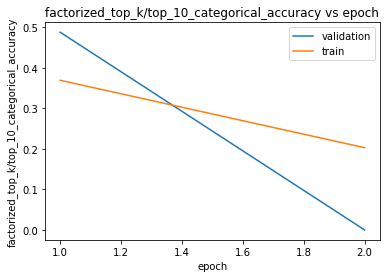

In [74]:
plot_metric(one_layer_history, 'factorized_top_k/top_10_categorical_accuracy')

## Evaluate

### Pretrained text model nnlm 50

In [320]:
model_link = 'https://tfhub.dev/google/nnlm-en-dim50/2'
#model_link = 'https://tfhub.dev/tensorflow/albert_en_large/2'

model = {"format": "text", "link": model_link}
recsys2 = ItemSimilarityModel(test_candidate_ids=unique_item_ids,
                                      features=['text_model'],
                                      feature_dims=[model],
                                      unique_item_ids=unique_item_ids,
                                      item_body_lookup=body_lookup_table,
                                      item_tags_lookup=tags_lookup_table,
                                      item_category_lookup=category_lookup_table,
                                      item_image_lookup=thumbnail_lookup_table,
                                      layer_sizes=[],
                                      pretrained_text_model=model_link)
recsys2.compile(optimizer=tf.keras.optimizers.Adagrad(lr))
recsys2_metrics = recsys2.evaluate(holdout_logs_tf.batch(128).cache())
recsys2_metrics


Using pretrained TEXT model: https://tfhub.dev/google/nnlm-en-dim50/2


552/552 [==============================] - 193s 349ms/step - factorized_top_k/top_1_categorical_accuracy: 0.0043 - factorized_top_k/top_5_categorical_accuracy: 0.0165 - factorized_top_k/top_10_categorical_accuracy: 0.0352 - factorized_top_k/top_50_categorical_accuracy: 0.0932 - factorized_top_k/top_100_categorical_accuracy: 0.1344 - loss: 5.8421 - regularization_loss: 0.0000e+00 - total_loss: 5.8421


[0.0042615849524736404,
 0.016451699659228325,
 0.03515453636646271,
 0.09321685880422592,
 0.13438858091831207]

### Pretrained text model nnlm 128

In [112]:
#model_link = 'https://tfhub.dev/google/nnlm-en-dim50/2'
#model_link = 'https://tfhub.dev/tensorflow/albert_en_large/2'
model_link = 'https://tfhub.dev/google/nnlm-en-dim128-with-normalization/2'

model = {"format": "text", "link": model_link}
recsys2 = ItemSimilarityModel(test_candidate_ids=unique_item_ids,
                                      features=['text_model'],
                                      feature_dims=[model],
                                      unique_item_ids=unique_item_ids,
                                      item_body_lookup=body_lookup_table,
                                      item_tags_lookup=tags_lookup_table,
                                      item_category_lookup=category_lookup_table,
                                      item_image_lookup=thumbnail_lookup_table,
                                      layer_sizes=[],
                                      pretrained_text_model=model_link)
recsys2.compile(optimizer=tf.keras.optimizers.Adagrad(lr))
recsys2_metrics = recsys2.evaluate(holdout_logs_tf.batch(128).cache())
recsys2_metrics


Using pretrained TEXT model: https://tfhub.dev/google/nnlm-en-dim128-with-normalization/2


552/552 [==============================] - 219s 397ms/step - factorized_top_k/top_1_categorical_accuracy: 0.0015 - factorized_top_k/top_5_categorical_accuracy: 0.0271 - factorized_top_k/top_10_categorical_accuracy: 0.0426 - factorized_top_k/top_50_categorical_accuracy: 0.1208 - factorized_top_k/top_100_categorical_accuracy: 0.1472 - loss: 13.6282 - regularization_loss: 0.0000e+00 - total_loss: 13.6282


[0.001458283164538443,
 0.027098583057522774,
 0.042615849524736404,
 0.12076850235462189,
 0.14720165729522705]

### Pretrained image model 

In [286]:
recsys2_im = ItemSimilarityModel(test_candidate_ids=unique_item_ids,
                                      features=['image_embedding'],
                                      feature_dims=[None],
                                      unique_item_ids=unique_item_ids,
                                      item_body_lookup=body_lookup_table,
                                      item_tags_lookup=tags_lookup_table,
                                      item_category_lookup=category_lookup_table,
                                      item_image_lookup=thumbnail_lookup_table,
                                      image_embedding_lookup_table=im_embeddings_lookup,
                                      layer_sizes=[])
recsys2_im.compile(optimizer=tf.keras.optimizers.Adagrad(lr))
recsys2_im_metrics = recsys2_im.evaluate(holdout_logs_tf.batch(128).cache())
recsys2_im_metrics


Using pretrained IMAGE model: https://tfhub.dev/google/imagenet/mobilenet_v2_100_96/feature_vector/4
552/552 [==============================] - 79s 143ms/step - factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_5_categorical_accuracy: 0.0031 - factorized_top_k/top_10_categorical_accuracy: 0.0120 - factorized_top_k/top_50_categorical_accuracy: 0.0499 - factorized_top_k/top_100_categorical_accuracy: 0.0787 - loss: 13.6808 - regularization_loss: 0.0000e+00 - total_loss: 13.6808


[0.0,
 0.003086463548243046,
 0.01203437615185976,
 0.04990726336836815,
 0.07871897518634796]

In [71]:
lr = 0.01
recsys2_im = ItemSimilarityModel(test_candidate_ids=unique_item_ids,
                                      features=['image_embedding'],
                                      feature_dims=[2048],
                                      unique_item_ids=unique_item_ids,
                                      item_body_lookup=body_lookup_table,
                                      item_tags_lookup=tags_lookup_table,
                                      item_category_lookup=category_lookup_table,
                                      item_image_lookup=thumbnail_lookup_table,
                                      image_embedding_lookup_table=im_vec_lookup_table,
                                      layer_sizes=[512, 100])
recsys2_im.compile(optimizer=tf.keras.optimizers.Adagrad(lr))
recsys2_im_metrics = recsys2_im.evaluate(holdout_logs_tf.batch(128).cache())
recsys2_im_metrics


ValueError: in user code:

    <ipython-input-6-e48051f929fe>:177 call  *
        return self.dense_layers(feature_embedding)
    /Users/mercef02/.virtualenvs/exploration-Tqzb7Mc2/lib/python3.7/site-packages/tensorflow/python/keras/engine/base_layer.py:976 __call__  **
        self.name)
    /Users/mercef02/.virtualenvs/exploration-Tqzb7Mc2/lib/python3.7/site-packages/tensorflow/python/keras/engine/input_spec.py:168 assert_input_compatibility
        layer_name + ' is incompatible with the layer: '

    ValueError: Input 0 of layer sequential_deep is incompatible with the layer: its rank is undefined, but the layer requires a defined rank.


### Pretrained image model and pretrained text model

In [287]:
model_link = 'https://tfhub.dev/google/nnlm-en-dim128-with-normalization/2'

text_model = {"format": "text", "link": model_link}

recsys2_im = ItemSimilarityModel(test_candidate_ids=unique_item_ids,
                                      features=['text_model', 'image_embedding'],
                                      feature_dims=[text_model, None],
                                      unique_item_ids=unique_item_ids,
                                      item_body_lookup=body_lookup_table,
                                      item_tags_lookup=tags_lookup_table,
                                      item_category_lookup=category_lookup_table,
                                      item_image_lookup=thumbnail_lookup_table,
                                      image_embedding_lookup_table=im_embeddings_lookup,
                                      layer_sizes=[])
recsys2_im.compile(optimizer=tf.keras.optimizers.Adagrad(lr))
recsys2_im_metrics = recsys2_im.evaluate(holdout_logs_tf.batch(128).cache())
recsys2_im_metrics

Using pretrained TEXT model: https://tfhub.dev/google/nnlm-en-dim128-with-normalization/2
552/552 [==============================] - 197s 357ms/step - factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_5_categorical_accuracy: 0.0032 - factorized_top_k/top_10_categorical_accuracy: 0.0118 - factorized_top_k/top_50_categorical_accuracy: 0.0499 - factorized_top_k/top_100_categorical_accuracy: 0.0799 - loss: 13.6803 - regularization_loss: 0.0000e+00 - total_loss: 13.6803


[0.0,
 0.0031855700071901083,
 0.011836162768304348,
 0.049864791333675385,
 0.07985161989927292]

### Pretrained text model tuned on siamese network

In [318]:
num_epochs = 3
lr = 0.01
cached_train = sfv_train.batch(128).cache()
cached_test = sfv_test.batch(128).cache()
model_link = 'https://tfhub.dev/google/nnlm-en-dim128-with-normalization/2'
text_model = {"format": "text", "link": model_link}
model_one_layer = ItemSimilarityModel(test_candidate_ids=unique_item_ids,
                                      features=['text_model'],
                                      feature_dims=[text_model],
                                      unique_item_ids=unique_item_ids,
                                      item_body_lookup=body_lookup_table,
                                      item_tags_lookup=tags_lookup_table,
                                      item_category_lookup=category_lookup_table,
                                      item_image_lookup=thumbnail_lookup_table,
                                      image_embedding_lookup_table=im_embeddings_lookup,
                                      layer_sizes=[64])
model_one_layer.compile(optimizer=tf.keras.optimizers.Adagrad(lr))

one_layer_history = model_one_layer.fit(
    cached_train,
    validation_data=cached_test,
    validation_freq=1,
    epochs=num_epochs,
    verbose=1)
#    callbacks=[tensorboard_callback])

print(f'Train accuracy: {one_layer_history.history["factorized_top_k/top_100_categorical_accuracy"][-1]}')   
print(f'Validation accuracy: {one_layer_history.history["val_factorized_top_k/top_100_categorical_accuracy"][-1]}')

text_deep_metrics = model_one_layer.evaluate(holdout_logs_tf.batch(128).cache())
text_deep_metrics

Using pretrained TEXT model: https://tfhub.dev/google/nnlm-en-dim128-with-normalization/2


Epoch 1/3


1704/1704 [==============================] - 503s 295ms/step - factorized_top_k/top_1_categorical_accuracy: 0.0025 - factorized_top_k/top_5_categorical_accuracy: 0.0080 - factorized_top_k/top_10_categorical_accuracy: 0.0104 - factorized_top_k/top_50_categorical_accuracy: 0.0322 - factorized_top_k/top_100_categorical_accuracy: 0.0528 - loss: 5.5050 - regularization_loss: 0.0000e+00 - total_loss: 5.5050 - val_factorized_top_k/top_1_categorical_accuracy: 0.0034 - val_factorized_top_k/top_5_categorical_accuracy: 0.0132 - val_factorized_top_k/top_10_categorical_accuracy: 0.0135 - val_factorized_top_k/top_50_categorical_accuracy: 0.0477 - val_factorized_top_k/top_100_categorical_accuracy: 0.0808 - val_loss: 8.8002 - val_regularization_loss: 0.0000e+00 - val_total_loss: 8.8002
Epoch 2/3
1704/1704 [==============================] - 576s 338ms/step - factorized_top_k/top_1_categorical_accuracy: 0.0031 - factorized_top_k/top_5_categorical_accuracy: 0.0160 - factorized_top_k/top_10_categorical_ac

[0.004573062993586063,
 0.018702836707234383,
 0.021690193563699722,
 0.05149297043681145,
 0.07713326811790466]

### Siamese network trained with item body text 

In [340]:
num_epochs = 3
lr = 0.01
cached_train = sfv_train.batch(128).cache()
cached_test = sfv_test.batch(128).cache()
model_link = 'https://tfhub.dev/google/nnlm-en-dim128-with-normalization/2'
text_model = {"format": "text", "link": model_link}
model_one_layer = ItemSimilarityModel(test_candidate_ids=unique_item_ids,
                                      features=['body'],
                                      feature_dims=[64],
                                      unique_item_ids=unique_item_ids,
                                      item_body_lookup=body_lookup_table,
                                      item_tags_lookup=tags_lookup_table,
                                      item_category_lookup=category_lookup_table,
                                      item_image_lookup=thumbnail_lookup_table,
                                      image_embedding_lookup_table=im_embeddings_lookup,
                                      layer_sizes=[],
                                      compute_metrics=True)
model_one_layer.compile(optimizer=tf.keras.optimizers.Adagrad(lr))

one_layer_history = model_one_layer.fit(
    cached_train,
    validation_data=cached_test,
    validation_freq=1,
    epochs=num_epochs,
    verbose=1)
#    callbacks=[tensorboard_callback])

print(f'Train accuracy: {one_layer_history.history["factorized_top_k/top_100_categorical_accuracy"][-1]}')   
print(f'Validation accuracy: {one_layer_history.history["val_factorized_top_k/top_100_categorical_accuracy"][-1]}')
model_one_layer.compute_metrics = True
text_deep_metrics = model_one_layer.evaluate(holdout_logs_tf.batch(128).cache())
text_deep_metrics

Epoch 1/3


1704/1704 [==============================] - 636s 373ms/step - factorized_top_k/top_1_categorical_accuracy: 0.8308 - factorized_top_k/top_5_categorical_accuracy: 0.8766 - factorized_top_k/top_10_categorical_accuracy: 0.8979 - factorized_top_k/top_50_categorical_accuracy: 0.9320 - factorized_top_k/top_100_categorical_accuracy: 0.9441 - loss: 4.8505 - regularization_loss: 0.0000e+00 - total_loss: 4.8505 - val_factorized_top_k/top_1_categorical_accuracy: 0.2928 - val_factorized_top_k/top_5_categorical_accuracy: 0.4839 - val_factorized_top_k/top_10_categorical_accuracy: 0.4937 - val_factorized_top_k/top_50_categorical_accuracy: 0.4972 - val_factorized_top_k/top_100_categorical_accuracy: 0.5209 - val_loss: 3.9120 - val_regularization_loss: 0.0000e+00 - val_total_loss: 3.9120
Epoch 2/3
1704/1704 [==============================] - 555s 326ms/step - factorized_top_k/top_1_categorical_accuracy: 0.4317 - factorized_top_k/top_5_categorical_accuracy: 0.4521 - factorized_top_k/top_10_categorical_ac

[0.0,
 8.494853682350367e-05,
 0.00016989707364700735,
 0.0017272868426516652,
 0.1595899760723114]

### Siamese network trained with item tags text

In [342]:
num_epochs = 3
lr = 0.01
cached_train = sfv_train.batch(128).cache()
cached_test = sfv_test.batch(128).cache()
model_link = 'https://tfhub.dev/google/nnlm-en-dim128-with-normalization/2'
text_model = {"format": "text", "link": model_link}
tags_one_layer = ItemSimilarityModel(test_candidate_ids=unique_item_ids,
                                      features=['tags'],
                                      feature_dims=[64],
                                      unique_item_ids=unique_item_ids,
                                      item_body_lookup=body_lookup_table,
                                      item_tags_lookup=tags_lookup_table,
                                      item_category_lookup=category_lookup_table,
                                      item_image_lookup=thumbnail_lookup_table,
                                      image_embedding_lookup_table=im_embeddings_lookup,
                                      layer_sizes=[])
tags_one_layer.compile(optimizer=tf.keras.optimizers.Adagrad(lr))

one_layer_history = tags_one_layer.fit(
    cached_train,
    validation_data=cached_test,
    validation_freq=1,
    epochs=num_epochs,
    verbose=1)
#    callbacks=[tensorboard_callback])

print(f'Train accuracy: {one_layer_history.history["factorized_top_k/top_100_categorical_accuracy"][-1]}')   
print(f'Validation accuracy: {one_layer_history.history["val_factorized_top_k/top_100_categorical_accuracy"][-1]}')

tags_deep_metrics = model_one_layer.evaluate(holdout_logs_tf.batch(128).cache())
tags_deep_metrics

Epoch 1/3


1704/1704 [==============================] - 296s 174ms/step - factorized_top_k/top_1_categorical_accuracy: 0.7071 - factorized_top_k/top_5_categorical_accuracy: 0.7391 - factorized_top_k/top_10_categorical_accuracy: 0.7437 - factorized_top_k/top_50_categorical_accuracy: 0.7478 - factorized_top_k/top_100_categorical_accuracy: 0.7514 - loss: 4.8505 - regularization_loss: 0.0000e+00 - total_loss: 4.8505 - val_factorized_top_k/top_1_categorical_accuracy: 0.1431 - val_factorized_top_k/top_5_categorical_accuracy: 0.1450 - val_factorized_top_k/top_10_categorical_accuracy: 0.1528 - val_factorized_top_k/top_50_categorical_accuracy: 0.1528 - val_factorized_top_k/top_100_categorical_accuracy: 0.1528 - val_loss: 3.9120 - val_regularization_loss: 0.0000e+00 - val_total_loss: 3.9120
Epoch 2/3
1704/1704 [==============================] - 308s 181ms/step - factorized_top_k/top_1_categorical_accuracy: 0.4259 - factorized_top_k/top_5_categorical_accuracy: 0.4719 - factorized_top_k/top_10_categorical_ac

RuntimeError: You must compile your model before training/testing. Use `model.compile(optimizer, loss)`.

In [344]:
tags_deep_metrics = tags_one_layer.evaluate(holdout_logs_tf.batch(128).cache())

552/552 [==============================] - 89s 161ms/step - factorized_top_k/top_1_categorical_accuracy: 0.9632 - factorized_top_k/top_5_categorical_accuracy: 0.9808 - factorized_top_k/top_10_categorical_accuracy: 0.9857 - factorized_top_k/top_50_categorical_accuracy: 0.9872 - factorized_top_k/top_100_categorical_accuracy: 0.9876 - loss: 4.8512 - regularization_loss: 0.0000e+00 - total_loss: 4.8512


### Siamese network trained with item tags text and body

In [345]:
num_epochs = 3
lr = 0.01
cached_train = sfv_train.batch(128).cache()
cached_test = sfv_test.batch(128).cache()
model_link = 'https://tfhub.dev/google/nnlm-en-dim128-with-normalization/2'
text_model = {"format": "text", "link": model_link}
tags_text_siamese = ItemSimilarityModel(test_candidate_ids=unique_item_ids,
                                      features=['tags', 'body'],
                                      feature_dims=[64, 64],
                                      unique_item_ids=unique_item_ids,
                                      item_body_lookup=body_lookup_table,
                                      item_tags_lookup=tags_lookup_table,
                                      item_category_lookup=category_lookup_table,
                                      item_image_lookup=thumbnail_lookup_table,
                                      image_embedding_lookup_table=im_embeddings_lookup,
                                      layer_sizes=[])
tags_text_siamese.compile(optimizer=tf.keras.optimizers.Adagrad(lr))

tags_text_history = tags_text_siamese.fit(
    cached_train,
    validation_data=cached_test,
    validation_freq=1,
    epochs=num_epochs,
    verbose=1)
#    callbacks=[tensorboard_callback])

print(f'Train accuracy: {tags_text_history.history["factorized_top_k/top_100_categorical_accuracy"][-1]}')   
print(f'Validation accuracy: {tags_text_history.history["val_factorized_top_k/top_100_categorical_accuracy"][-1]}')

tags_text_metrics = tags_text_siamese.evaluate(holdout_logs_tf.batch(128).cache())
tags_text_metrics

Epoch 1/3


1704/1704 [==============================] - 723s 424ms/step - factorized_top_k/top_1_categorical_accuracy: 0.0140 - factorized_top_k/top_5_categorical_accuracy: 0.0587 - factorized_top_k/top_10_categorical_accuracy: 0.0695 - factorized_top_k/top_50_categorical_accuracy: 0.0869 - factorized_top_k/top_100_categorical_accuracy: 0.0950 - loss: 4.8505 - regularization_loss: 0.0000e+00 - total_loss: 4.8505 - val_factorized_top_k/top_1_categorical_accuracy: 0.0088 - val_factorized_top_k/top_5_categorical_accuracy: 0.3333 - val_factorized_top_k/top_10_categorical_accuracy: 0.4036 - val_factorized_top_k/top_50_categorical_accuracy: 0.6738 - val_factorized_top_k/top_100_categorical_accuracy: 0.9617 - val_loss: 3.9120 - val_regularization_loss: 0.0000e+00 - val_total_loss: 3.9120
Epoch 2/3
1704/1704 [==============================] - 653s 383ms/step - factorized_top_k/top_1_categorical_accuracy: 0.6046 - factorized_top_k/top_5_categorical_accuracy: 0.6613 - factorized_top_k/top_10_categorical_ac

[4.2474268411751837e-05,
 0.0003964265051763505,
 0.0003964265051763505,
 0.0016564964316785336,
 0.002067080931738019]

### Deep Siamese network trained with item tags text and body

In [346]:
num_epochs = 3
lr = 0.01
cached_train = sfv_train.batch(128).cache()
cached_test = sfv_test.batch(128).cache()
model_link = 'https://tfhub.dev/google/nnlm-en-dim128-with-normalization/2'
text_model = {"format": "text", "link": model_link}
tags_body_deep = ItemSimilarityModel(test_candidate_ids=unique_item_ids,
                                      features=['tags', 'body'],
                                      feature_dims=[64, 64],
                                      unique_item_ids=unique_item_ids,
                                      item_body_lookup=body_lookup_table,
                                      item_tags_lookup=tags_lookup_table,
                                      item_category_lookup=category_lookup_table,
                                      item_image_lookup=thumbnail_lookup_table,
                                      image_embedding_lookup_table=im_embeddings_lookup,
                                      layer_sizes=[96])
tags_body_deep.compile(optimizer=tf.keras.optimizers.Adagrad(lr))

tags_body_deep_metrics = tags_body_deep.fit(
    cached_train,
    validation_data=cached_test,
    validation_freq=1,
    epochs=num_epochs,
    verbose=1)
#    callbacks=[tensorboard_callback])

print(f'Train accuracy: {tags_body_deep_metrics.history["factorized_top_k/top_100_categorical_accuracy"][-1]}')   
print(f'Validation accuracy: {tags_body_deep_metrics.history["val_factorized_top_k/top_100_categorical_accuracy"][-1]}')

tags_body_deep_metrics = tags_body_deep.evaluate(holdout_logs_tf.batch(128).cache())
tags_body_deep_metrics

Epoch 1/3


1704/1704 [==============================] - 746s 438ms/step - factorized_top_k/top_1_categorical_accuracy: 0.3441 - factorized_top_k/top_5_categorical_accuracy: 0.6136 - factorized_top_k/top_10_categorical_accuracy: 0.6474 - factorized_top_k/top_50_categorical_accuracy: 0.6939 - factorized_top_k/top_100_categorical_accuracy: 0.7140 - loss: 4.8505 - regularization_loss: 0.0000e+00 - total_loss: 4.8505 - val_factorized_top_k/top_1_categorical_accuracy: 0.0950 - val_factorized_top_k/top_5_categorical_accuracy: 0.9800 - val_factorized_top_k/top_10_categorical_accuracy: 0.9807 - val_factorized_top_k/top_50_categorical_accuracy: 0.9846 - val_factorized_top_k/top_100_categorical_accuracy: 0.9849 - val_loss: 3.9120 - val_regularization_loss: 0.0000e+00 - val_total_loss: 3.9120
Epoch 2/3
1704/1704 [==============================] - 690s 405ms/step - factorized_top_k/top_1_categorical_accuracy: 0.2354 - factorized_top_k/top_5_categorical_accuracy: 0.4494 - factorized_top_k/top_10_categorical_ac

[0.00788605585694313,
 0.01687644235789776,
 0.016890600323677063,
 0.01694723218679428,
 0.01694723218679428]

### Deep Siamese network trained with item category and body

In [348]:
num_epochs = 3
lr = 0.01
cached_train = sfv_train.batch(128).cache()
cached_test = sfv_test.batch(128).cache()
model_link = 'https://tfhub.dev/google/nnlm-en-dim128-with-normalization/2'
text_model = {"format": "text", "link": model_link}
tags_body_deep = ItemSimilarityModel(test_candidate_ids=unique_item_ids,
                                      features=['category', 'body'],
                                      feature_dims=[64, 64],
                                      unique_item_ids=unique_item_ids,
                                      item_body_lookup=body_lookup_table,
                                      item_tags_lookup=tags_lookup_table,
                                      item_category_lookup=category_lookup_table,
                                      item_image_lookup=thumbnail_lookup_table,
                                      image_embedding_lookup_table=im_embeddings_lookup,
                                      layer_sizes=[96])
tags_body_deep.compile(optimizer=tf.keras.optimizers.Adagrad(lr))

tags_body_deep_metrics = tags_body_deep.fit(
    cached_train,
    validation_data=cached_test,
    validation_freq=1,
    epochs=num_epochs,
    verbose=1)
#    callbacks=[tensorboard_callback])

print(f'Train accuracy: {tags_body_deep_metrics.history["factorized_top_k/top_100_categorical_accuracy"][-1]}')   
print(f'Validation accuracy: {tags_body_deep_metrics.history["val_factorized_top_k/top_100_categorical_accuracy"][-1]}')

tags_body_deep_metrics = tags_body_deep.evaluate(holdout_logs_tf.batch(128).cache())
tags_body_deep_metrics

Epoch 1/3


1704/1704 [==============================] - 657s 386ms/step - factorized_top_k/top_1_categorical_accuracy: 0.1241 - factorized_top_k/top_5_categorical_accuracy: 0.1245 - factorized_top_k/top_10_categorical_accuracy: 0.1245 - factorized_top_k/top_50_categorical_accuracy: 0.1353 - factorized_top_k/top_100_categorical_accuracy: 0.1606 - loss: 8.1411 - regularization_loss: 0.0000e+00 - total_loss: 8.1411 - val_factorized_top_k/top_1_categorical_accuracy: 0.1260 - val_factorized_top_k/top_5_categorical_accuracy: 0.1286 - val_factorized_top_k/top_10_categorical_accuracy: 0.1313 - val_factorized_top_k/top_50_categorical_accuracy: 0.1727 - val_factorized_top_k/top_100_categorical_accuracy: 0.1986 - val_loss: 8.5321 - val_regularization_loss: 0.0000e+00 - val_total_loss: 8.5321
Epoch 2/3
1704/1704 [==============================] - 572s 335ms/step - factorized_top_k/top_1_categorical_accuracy: 0.1220 - factorized_top_k/top_5_categorical_accuracy: 0.1220 - factorized_top_k/top_10_categorical_ac

[0.13383641839027405,
 0.21135196089744568,
 0.21207401156425476,
 0.25039997696876526,
 0.28076907992362976]

###  Siamese network trained with item category and body

In [349]:
num_epochs = 3
lr = 0.01
cached_train = sfv_train.batch(128).cache()
cached_test = sfv_test.batch(128).cache()
model_link = 'https://tfhub.dev/google/nnlm-en-dim128-with-normalization/2'
text_model = {"format": "text", "link": model_link}
tags_body_deep = ItemSimilarityModel(test_candidate_ids=unique_item_ids,
                                      features=['category', 'body'],
                                      feature_dims=[64, 64],
                                      unique_item_ids=unique_item_ids,
                                      item_body_lookup=body_lookup_table,
                                      item_tags_lookup=tags_lookup_table,
                                      item_category_lookup=category_lookup_table,
                                      item_image_lookup=thumbnail_lookup_table,
                                      image_embedding_lookup_table=im_embeddings_lookup,
                                      layer_sizes=[])
tags_body_deep.compile(optimizer=tf.keras.optimizers.Adagrad(lr))

tags_body_deep_metrics = tags_body_deep.fit(
    cached_train,
    validation_data=cached_test,
    validation_freq=1,
    epochs=num_epochs,
    verbose=1)
#    callbacks=[tensorboard_callback])

print(f'Train accuracy: {tags_body_deep_metrics.history["factorized_top_k/top_100_categorical_accuracy"][-1]}')   
print(f'Validation accuracy: {tags_body_deep_metrics.history["val_factorized_top_k/top_100_categorical_accuracy"][-1]}')

tags_body_deep_metrics = tags_body_deep.evaluate(holdout_logs_tf.batch(128).cache())
tags_body_deep_metrics

Epoch 1/3


1704/1704 [==============================] - 604s 355ms/step - factorized_top_k/top_1_categorical_accuracy: 0.1008 - factorized_top_k/top_5_categorical_accuracy: 0.1013 - factorized_top_k/top_10_categorical_accuracy: 0.1015 - factorized_top_k/top_50_categorical_accuracy: 0.1130 - factorized_top_k/top_100_categorical_accuracy: 0.1380 - loss: 8.6451 - regularization_loss: 0.0000e+00 - total_loss: 8.6451 - val_factorized_top_k/top_1_categorical_accuracy: 0.2182 - val_factorized_top_k/top_5_categorical_accuracy: 0.2192 - val_factorized_top_k/top_10_categorical_accuracy: 0.2193 - val_factorized_top_k/top_50_categorical_accuracy: 0.2220 - val_factorized_top_k/top_100_categorical_accuracy: 0.2450 - val_loss: 7.4189 - val_regularization_loss: 0.0000e+00 - val_total_loss: 7.4189
Epoch 2/3
1704/1704 [==============================] - 526s 309ms/step - factorized_top_k/top_1_categorical_accuracy: 0.1016 - factorized_top_k/top_5_categorical_accuracy: 0.1020 - factorized_top_k/top_10_categorical_ac

[0.11613880842924118,
 0.11659186333417892,
 0.11659186333417892,
 0.12143392860889435,
 0.1405048817396164]

### Pure CF embeddings

In [347]:
num_epochs = 3
lr = 0.01
cached_train = sfv_train.batch(128).cache()
cached_test = sfv_test.batch(128).cache()
model_link = 'https://tfhub.dev/google/nnlm-en-dim128-with-normalization/2'
text_model = {"format": "text", "link": model_link}
cf_one_layer = ItemSimilarityModel(test_candidate_ids=unique_item_ids,
                                      features=['item_id'],
                                      feature_dims=[100],
                                      unique_item_ids=unique_item_ids,
                                      item_body_lookup=body_lookup_table,
                                      item_tags_lookup=tags_lookup_table,
                                      item_category_lookup=category_lookup_table,
                                      item_image_lookup=thumbnail_lookup_table,
                                      image_embedding_lookup_table=im_embeddings_lookup,
                                      layer_sizes=[])
cf_one_layer.compile(optimizer=tf.keras.optimizers.Adagrad(lr))

cf_one_layer_history = cf_one_layer.fit(
    cached_train,
    validation_data=cached_test,
    validation_freq=1,
    epochs=num_epochs,
    verbose=1)
#    callbacks=[tensorboard_callback])

print(f'Train accuracy: {one_layer_history.history["factorized_top_k/top_100_categorical_accuracy"][-1]}')   
print(f'Validation accuracy: {one_layer_history.history["val_factorized_top_k/top_100_categorical_accuracy"][-1]}')

id_metrics = cf_one_layer.evaluate(holdout_logs_tf.batch(128).cache())
id_metrics

Epoch 1/3


1704/1704 [==============================] - 139s 82ms/step - factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_5_categorical_accuracy: 0.0920 - factorized_top_k/top_10_categorical_accuracy: 0.1408 - factorized_top_k/top_50_categorical_accuracy: 0.2360 - factorized_top_k/top_100_categorical_accuracy: 0.2791 - loss: 8.9186 - regularization_loss: 0.0000e+00 - total_loss: 8.9186 - val_factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - val_factorized_top_k/top_5_categorical_accuracy: 0.1223 - val_factorized_top_k/top_10_categorical_accuracy: 0.1803 - val_factorized_top_k/top_50_categorical_accuracy: 0.2479 - val_factorized_top_k/top_100_categorical_accuracy: 0.2944 - val_loss: 6.2466 - val_regularization_loss: 0.0000e+00 - val_total_loss: 6.2466
Epoch 2/3
1704/1704 [==============================] - 140s 82ms/step - factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_5_categorical_accuracy: 0.1180 - factorized_top_k/top_10_cate

[0.0,
 0.1478104442358017,
 0.17544704675674438,
 0.23131486773490906,
 0.2577621638774872]

###  CF + body + category embeddings

In [350]:
num_epochs = 3
lr = 0.01
cached_train = sfv_train.batch(128).cache()
cached_test = sfv_test.batch(128).cache()
model_link = 'https://tfhub.dev/google/nnlm-en-dim128-with-normalization/2'
text_model = {"format": "text", "link": model_link}
cf_one_layer = ItemSimilarityModel(test_candidate_ids=unique_item_ids,
                                      features=['item_id', 'body', 'category'],
                                      feature_dims=[64, 64, 64],
                                      unique_item_ids=unique_item_ids,
                                      item_body_lookup=body_lookup_table,
                                      item_tags_lookup=tags_lookup_table,
                                      item_category_lookup=category_lookup_table,
                                      item_image_lookup=thumbnail_lookup_table,
                                      image_embedding_lookup_table=im_embeddings_lookup,
                                      layer_sizes=[96])
cf_one_layer.compile(optimizer=tf.keras.optimizers.Adagrad(lr))

cf_one_layer_history = cf_one_layer.fit(
    cached_train,
    validation_data=cached_test,
    validation_freq=1,
    epochs=num_epochs,
    verbose=1)
#    callbacks=[tensorboard_callback])

print(f'Train accuracy: {one_layer_history.history["factorized_top_k/top_100_categorical_accuracy"][-1]}')   
print(f'Validation accuracy: {one_layer_history.history["val_factorized_top_k/top_100_categorical_accuracy"][-1]}')

id_metrics = cf_one_layer.evaluate(holdout_logs_tf.batch(128).cache())
id_metrics

Epoch 1/3


1704/1704 [==============================] - 635s 373ms/step - factorized_top_k/top_1_categorical_accuracy: 0.0179 - factorized_top_k/top_5_categorical_accuracy: 0.1033 - factorized_top_k/top_10_categorical_accuracy: 0.1400 - factorized_top_k/top_50_categorical_accuracy: 0.2147 - factorized_top_k/top_100_categorical_accuracy: 0.2598 - loss: 8.1931 - regularization_loss: 0.0000e+00 - total_loss: 8.1931 - val_factorized_top_k/top_1_categorical_accuracy: 0.0143 - val_factorized_top_k/top_5_categorical_accuracy: 0.0896 - val_factorized_top_k/top_10_categorical_accuracy: 0.1346 - val_factorized_top_k/top_50_categorical_accuracy: 0.1858 - val_factorized_top_k/top_100_categorical_accuracy: 0.2609 - val_loss: 8.7385 - val_regularization_loss: 0.0000e+00 - val_total_loss: 8.7385
Epoch 2/3
1704/1704 [==============================] - 561s 329ms/step - factorized_top_k/top_1_categorical_accuracy: 0.0172 - factorized_top_k/top_5_categorical_accuracy: 0.1251 - factorized_top_k/top_10_categorical_ac

[0.019240843132138252,
 0.0867890864610672,
 0.11547337472438812,
 0.19494272768497467,
 0.25967350602149963]

###  CF + body  embeddings

In [352]:
num_epochs = 3
lr = 0.01
cached_train = sfv_train.batch(128).cache()
cached_test = sfv_test.batch(128).cache()
model_link = 'https://tfhub.dev/google/nnlm-en-dim128-with-normalization/2'
text_model = {"format": "text", "link": model_link}
cf_one_layer = ItemSimilarityModel(test_candidate_ids=unique_item_ids,
                                      features=['item_id', 'body'],
                                      feature_dims=[100, 64],
                                      unique_item_ids=unique_item_ids,
                                      item_body_lookup=body_lookup_table,
                                      item_tags_lookup=tags_lookup_table,
                                      item_category_lookup=category_lookup_table,
                                      item_image_lookup=thumbnail_lookup_table,
                                      image_embedding_lookup_table=im_embeddings_lookup,
                                      layer_sizes=[100])
cf_one_layer.compile(optimizer=tf.keras.optimizers.Adagrad(lr))

cf_one_layer_history = cf_one_layer.fit(
    cached_train,
    validation_data=cached_test,
    validation_freq=1,
    epochs=num_epochs,
    verbose=1)
#    callbacks=[tensorboard_callback])

print(f'Train accuracy: {one_layer_history.history["factorized_top_k/top_100_categorical_accuracy"][-1]}')   
print(f'Validation accuracy: {one_layer_history.history["val_factorized_top_k/top_100_categorical_accuracy"][-1]}')

id_metrics = cf_one_layer.evaluate(holdout_logs_tf.batch(128).cache())
id_metrics

Epoch 1/3


1704/1704 [==============================] - 600s 352ms/step - factorized_top_k/top_1_categorical_accuracy: 0.0115 - factorized_top_k/top_5_categorical_accuracy: 0.1137 - factorized_top_k/top_10_categorical_accuracy: 0.1675 - factorized_top_k/top_50_categorical_accuracy: 0.2580 - factorized_top_k/top_100_categorical_accuracy: 0.2865 - loss: 5.2211 - regularization_loss: 0.0000e+00 - total_loss: 5.2211 - val_factorized_top_k/top_1_categorical_accuracy: 0.0120 - val_factorized_top_k/top_5_categorical_accuracy: 0.1999 - val_factorized_top_k/top_10_categorical_accuracy: 0.2934 - val_factorized_top_k/top_50_categorical_accuracy: 0.4277 - val_factorized_top_k/top_100_categorical_accuracy: 0.4447 - val_loss: 4.9520 - val_regularization_loss: 0.0000e+00 - val_total_loss: 4.9520
Epoch 2/3
1704/1704 [==============================] - 507s 297ms/step - factorized_top_k/top_1_categorical_accuracy: 0.0243 - factorized_top_k/top_5_categorical_accuracy: 0.2088 - factorized_top_k/top_10_categorical_ac

[0.0201894361525774,
 0.15136413276195526,
 0.23360846936702728,
 0.3986351490020752,
 0.43557360768318176]

In [310]:
num_epochs = 2
lr = 0.01
cached_train = sfv_train.batch(128).cache()
cached_test = sfv_test.batch(128).cache()
#model_link = 'https://tfhub.dev/google/nnlm-en-dim128-with-normalization/2'
#text_model = {"format": "text", "link": model_link}
recsys2_im = ItemSimilarityModel(test_candidate_ids=unique_item_ids,
                                      features=['image_embedding'],
                                      feature_dims=[None],
                                      unique_item_ids=unique_item_ids,
                                      item_body_lookup=body_lookup_table,
                                      item_tags_lookup=tags_lookup_table,
                                      item_category_lookup=category_lookup_table,
                                      item_image_lookup=thumbnail_lookup_table,
                                      image_embedding_lookup_table=im_embeddings_lookup,
                                      layer_sizes=[])

recsys2_im.compile(optimizer=tf.keras.optimizers.Adagrad(lr))
recsys2_im.fit(    cached_train,
    validation_data=cached_test,
    validation_freq=1,
    epochs=num_epochs,
    verbose=1)


print(f'Train accuracy: {one_layer_history.history["factorized_top_k/top_100_categorical_accuracy"][-1]}')   
print(f'Validation accuracy: {one_layer_history.history["val_factorized_top_k/top_100_categorical_accuracy"][-1]}')

recsys2_im_metrics = recsys2_im.evaluate(holdout_logs_tf.batch(128).cache())

recsys2_im_metrics

Epoch 1/2


ValueError: in user code:

    /Users/mercef02/.virtualenvs/exploration-Tqzb7Mc2/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:806 train_function  *
        return step_function(self, iterator)
    /Users/mercef02/.virtualenvs/exploration-Tqzb7Mc2/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:796 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /Users/mercef02/.virtualenvs/exploration-Tqzb7Mc2/lib/python3.7/site-packages/tensorflow/python/distribute/distribute_lib.py:1211 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /Users/mercef02/.virtualenvs/exploration-Tqzb7Mc2/lib/python3.7/site-packages/tensorflow/python/distribute/distribute_lib.py:2585 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /Users/mercef02/.virtualenvs/exploration-Tqzb7Mc2/lib/python3.7/site-packages/tensorflow/python/distribute/distribute_lib.py:2945 _call_for_each_replica
        return fn(*args, **kwargs)
    /Users/mercef02/.virtualenvs/exploration-Tqzb7Mc2/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:789 run_step  **
        outputs = model.train_step(data)
    /Users/mercef02/.virtualenvs/exploration-Tqzb7Mc2/lib/python3.7/site-packages/tensorflow_recommenders/models/base.py:76 train_step
        self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))
    /Users/mercef02/.virtualenvs/exploration-Tqzb7Mc2/lib/python3.7/site-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:513 apply_gradients
        grads_and_vars = _filter_grads(grads_and_vars)
    /Users/mercef02/.virtualenvs/exploration-Tqzb7Mc2/lib/python3.7/site-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:1271 _filter_grads
        ([v.name for _, v in grads_and_vars],))

    ValueError: No gradients provided for any variable: ['counter:0'].


In [352]:
num_epochs = 3
lr = 0.01
cached_train = sfv_train.batch(128).cache()
cached_test = sfv_test.batch(128).cache()
cf_one_layer = ItemSimilarityModel(test_candidate_ids=unique_item_ids,
                                      features=['item_id', 'body'],
                                      feature_dims=[100, 64],
                                      unique_item_ids=unique_item_ids,
                                      item_body_lookup=body_lookup_table,
                                      item_tags_lookup=tags_lookup_table,
                                      item_category_lookup=category_lookup_table,
                                      item_image_lookup=thumbnail_lookup_table,
                                      image_embedding_lookup_table=im_embeddings_lookup,
                                      layer_sizes=[100])
cf_one_layer.compile(optimizer=tf.keras.optimizers.Adagrad(lr))

cf_one_layer_history = cf_one_layer.fit(
    cached_train,
    validation_data=cached_test,
    validation_freq=1,
    epochs=num_epochs,
    verbose=1)
#    callbacks=[tensorboard_callback])

print(f'Train accuracy: {one_layer_history.history["factorized_top_k/top_100_categorical_accuracy"][-1]}')   
print(f'Validation accuracy: {one_layer_history.history["val_factorized_top_k/top_100_categorical_accuracy"][-1]}')

id_metrics = cf_one_layer.evaluate(holdout_logs_tf.batch(128).cache())
id_metrics

Epoch 1/3


1704/1704 [==============================] - 600s 352ms/step - factorized_top_k/top_1_categorical_accuracy: 0.0115 - factorized_top_k/top_5_categorical_accuracy: 0.1137 - factorized_top_k/top_10_categorical_accuracy: 0.1675 - factorized_top_k/top_50_categorical_accuracy: 0.2580 - factorized_top_k/top_100_categorical_accuracy: 0.2865 - loss: 5.2211 - regularization_loss: 0.0000e+00 - total_loss: 5.2211 - val_factorized_top_k/top_1_categorical_accuracy: 0.0120 - val_factorized_top_k/top_5_categorical_accuracy: 0.1999 - val_factorized_top_k/top_10_categorical_accuracy: 0.2934 - val_factorized_top_k/top_50_categorical_accuracy: 0.4277 - val_factorized_top_k/top_100_categorical_accuracy: 0.4447 - val_loss: 4.9520 - val_regularization_loss: 0.0000e+00 - val_total_loss: 4.9520
Epoch 2/3
1704/1704 [==============================] - 507s 297ms/step - factorized_top_k/top_1_categorical_accuracy: 0.0243 - factorized_top_k/top_5_categorical_accuracy: 0.2088 - factorized_top_k/top_10_categorical_ac

[0.0201894361525774,
 0.15136413276195526,
 0.23360846936702728,
 0.3986351490020752,
 0.43557360768318176]

In [75]:
num_epochs = 10
lr = 0.01
cached_train = sfv_train.take(256).batch(128).cache()
cached_test = sfv_val.take(256).batch(128).cache()
cf_one_layer = ItemSimilarityModel(test_candidate_ids=unique_item_ids,
                                      features=['item_id', 'body'],
                                      feature_dims=[100, 64],
                                      unique_item_ids=unique_item_ids,
                                      item_body_lookup=body_lookup_table,
                                      item_tags_lookup=tags_lookup_table,
                                      item_category_lookup=category_lookup_table,
                                      item_image_lookup=thumbnail_lookup_table,
                                      image_embedding_lookup_table=im_embeddings_lookup,
                                      layer_sizes=[])
cf_one_layer.compile(optimizer=tf.keras.optimizers.Adagrad(lr))

cf_one_layer_history = cf_one_layer.fit(
    cached_train,
    validation_data=sfv_val,
    validation_freq=1,
    epochs=num_epochs,
    verbose=1)
#    callbacks=[tensorboard_callback])

print(f'Train accuracy: {one_layer_history.history["factorized_top_k/top_100_categorical_accuracy"][-1]}')   
print(f'Validation accuracy: {one_layer_history.history["val_factorized_top_k/top_100_categorical_accuracy"][-1]}')

id_metrics = cf_one_layer.evaluate(holdout_logs_tf.batch(128).cache())
id_metrics

Epoch 1/10


2/2 [==============================] - ETA: 0s - factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_5_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_10_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_50_categorical_accuracy: 0.0039 - factorized_top_k/top_100_categorical_accuracy: 0.0039 - loss: 4.8954 - regularization_loss: 0.0000e+00 - total_loss: 4.8954        WARNING:tensorflow:Model was constructed with shape (None,) for input Tensor("item_id_string_lookup_layer_input_6:0", shape=(None,), dtype=string), but it was called on an input with incompatible shape ().


ValueError: in user code:

    /Users/mercef02/.virtualenvs/exploration-Tqzb7Mc2/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1224 test_function  *
        return step_function(self, iterator)
    <ipython-input-6-e48051f929fe>:104 call  *
        feature_embeddings.append(self.body_embedding(body))
    /Users/mercef02/.virtualenvs/exploration-Tqzb7Mc2/lib/python3.7/site-packages/tensorflow/python/keras/engine/base_layer.py:985 __call__  **
        outputs = call_fn(inputs, *args, **kwargs)
    /Users/mercef02/.virtualenvs/exploration-Tqzb7Mc2/lib/python3.7/site-packages/tensorflow/python/keras/engine/sequential.py:372 call
        return super(Sequential, self).call(inputs, training=training, mask=mask)
    /Users/mercef02/.virtualenvs/exploration-Tqzb7Mc2/lib/python3.7/site-packages/tensorflow/python/keras/engine/functional.py:386 call
        inputs, training=training, mask=mask)
    /Users/mercef02/.virtualenvs/exploration-Tqzb7Mc2/lib/python3.7/site-packages/tensorflow/python/keras/engine/functional.py:508 _run_internal_graph
        outputs = node.layer(*args, **kwargs)
    /Users/mercef02/.virtualenvs/exploration-Tqzb7Mc2/lib/python3.7/site-packages/tensorflow/python/keras/engine/base_layer.py:976 __call__
        self.name)
    /Users/mercef02/.virtualenvs/exploration-Tqzb7Mc2/lib/python3.7/site-packages/tensorflow/python/keras/engine/input_spec.py:180 assert_input_compatibility
        str(x.shape.as_list()))

    ValueError: Input 0 of layer body_global_averaging_pooling_layer is incompatible with the layer: expected ndim=3, found ndim=2. Full shape received: [None, 64]


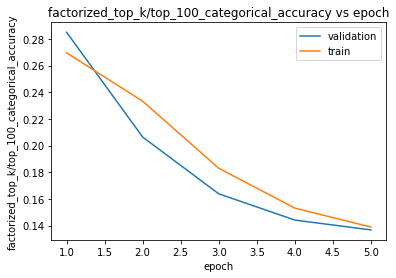

In [33]:
metric = 'factorized_top_k/top_100_categorical_accuracy'
#metric = 'loss'
#metric = 'total_loss'
plot_metric(one_layer_history, metric)

In [510]:
toy_model_two_layer.item_model.summary()



Model: "deep_item_model_40"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
item_embedding_model_38 (Ite multiple                  73952     
_________________________________________________________________
sequential_90 (Sequential)   (None, 32)                4192      
Total params: 78,144
Trainable params: 78,144
Non-trainable params: 0
_________________________________________________________________


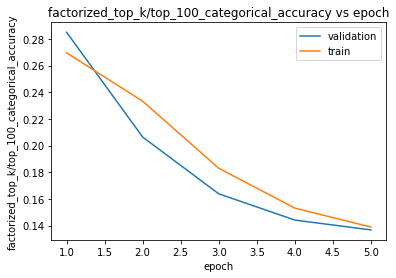

In [33]:
metric = 'factorized_top_k/top_100_categorical_accuracy'
#metric = 'loss'
#metric = 'total_loss'
plot_metric(one_layer_history, metric)

In [511]:
toy_model_one_layer.item_model.summary()

Model: "deep_item_model_39"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
item_embedding_model_37 (Ite multiple                  393952    
_________________________________________________________________
sequential_88 (Sequential)   (None, 64)                4160      
Total params: 398,112
Trainable params: 398,112
Non-trainable params: 0
_________________________________________________________________


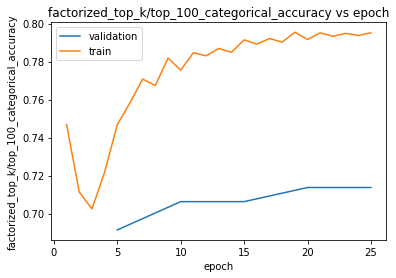

In [505]:
plot_metric(two_layer_history, 'factorized_top_k/top_100_categorical_accuracy')

In [241]:
trained_model = content_model
#trained_model = toy_model_two_layer

In [33]:
trained_model.item_model.summary()

Model: "deep_item_model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
item_embedding_model_3 (Item multiple                  3133056   
_________________________________________________________________
sequential_deep (Sequential) (None, 64)                4160      
Total params: 3,137,216
Trainable params: 3,137,216
Non-trainable params: 0
_________________________________________________________________


## Export embeddings into nearest neighbour index

In [242]:
item_embeddings = items_tf.batch(1).enumerate().map(lambda i, item_id: {'uri': item_id[0], 'id': i, 'embedding': trained_model.item_model(item_id)[0]})

In [243]:
embedding_dimension = len(item_embeddings.as_numpy_iterator().next().get('embedding'))
annoy_index = AnnoyIndex(embedding_dimension, "angular")
id_to_uri = {}
uri_to_id = {}
uri_to_embedding = {}

for item_embedding in item_embeddings.as_numpy_iterator():

    annoy_index.add_item(item_embedding['id'], item_embedding['embedding'])
    id_to_uri[item_embedding['id']] = str(item_embedding['uri'], 'utf-8')
    uri_to_id[str(item_embedding['uri'], 'utf-8')] =  item_embedding['id']
    uri_to_embedding[str(item_embedding['uri'], 'utf-8')] = item_embedding['embedding']

# Build a 10-tree ANN index.
annoy_index.build(100)


# Use brute-force search to set up retrieval using the trained representations.
# index = tfrs.layers.ann.BruteForce(trained_model.item_model)
# index.index(items_tf.batch(100).map(trained_model.item_model), items_tf)
# # Get some recommendations.
# query_uri = '/news/business-10665047'
# query_uri = '129'
# _, titles = index(np.array([query_uri]))
# print(f"Top 3 recommendations for item {query_uri}: {titles[0, :3]}")

True

In [244]:
em = []
for item_embedding in item_embeddings.as_numpy_iterator():
    em.append(item_embedding['embedding'])

In [72]:
pd.DataFrame(uri_to_embedding).to_csv('layers_64_lr0_01_epoch2_batch_4096_dummy.csv')


## Are the results sensible?

In [245]:
# Let's get the most paired items
query_uri, groundtruth_uri = vc.index[1].split('_')
print(f'query_uri = {query_uri}')
print(f'groundtruth_uri = {groundtruth_uri}')

query_uri = /news/world-us-canada-54745441
groundtruth_uri = /news/world-us-canada-54745441


In [246]:

#query_uri = '/news/technology-53018000'
#query_uri = '/sport/football/53805003'
#query_uri = '/news/business-10665047'
#query_uri = '/news/uk-england-hampshire-53838761'

rec_uris = generate_model_recs(query_uri, annoy_index, uri_to_id, id_to_uri, uri_to_embedding, es, _es_index, 20)
print(f'LITMUS TEST: {groundtruth_uri in rec_uris}')
print('-------------------')
print('-------------------')

for rec in rec_uris:
    print_item(rec, es, _es_index)
    print('-------------------')

Generating recommendations for:
/news/world-us-canada-54745441 
 Clive Myrie has visited the Navajo Nation in Arizona where the death rate is the highest in the US.
-------------------
-------------------
LITMUS TEST: True
-------------------
-------------------
/news/world-us-canada-54741189 
 Zeta made landfall in Louisiana as a hurricane but has since been downgraded to a tropical storm.
-------------------
/news/world-us-canada-54740177 
 Village People's lead singer says he doesn't endorse the US president, who regularly plays the classic at rallies.
-------------------
/news/world-us-canada-54640955 
 President Donald Trump and his predecessor, Barack Obama, launch withering attacks on each other.
-------------------
/news/world-us-canada-54491825 
 The US state is still recovering from the damage caused by a previous hurricane in August.
-------------------
/news/world-us-canada-53261067 
 White House Press Secretary Kayleigh McEnany defends Trump's comments on the Black Lives M

In [ ]:
len(unique_item_ids)

In [454]:
trained_model.item_model

## Export embeddings into nearest neighbour index

In [50]:
item_embeddings = items_tf.batch(1).enumerate().map(lambda i, item_id: {'uri': item_id[0], 'id': i, 'embedding': trained_model.item_model(item_id)[0]})

In [51]:
embedding_dimension = len(item_embeddings.as_numpy_iterator().next().get('embedding'))
annoy_index = AnnoyIndex(embedding_dimension, "angular")
id_to_uri = {}
uri_to_id = {}
uri_to_embedding = {}

for item_embedding in item_embeddings.as_numpy_iterator():

    annoy_index.add_item(item_embedding['id'], item_embedding['embedding'])
    id_to_uri[item_embedding['id']] = str(item_embedding['uri'], 'utf-8')
    uri_to_id[str(item_embedding['uri'], 'utf-8')] =  item_embedding['id']
    uri_to_embedding[str(item_embedding['uri'], 'utf-8')] = item_embedding['embedding']

# Build a 10-tree ANN index.
annoy_index.build(100)


# Use brute-force search to set up retrieval using the trained representations.
# index = tfrs.layers.ann.BruteForce(trained_model.item_model)
# index.index(items_tf.batch(100).map(trained_model.item_model), items_tf)
# # Get some recommendations.
# query_uri = '/news/business-10665047'
# query_uri = '129'
# _, titles = index(np.array([query_uri]))
# print(f"Top 3 recommendations for item {query_uri}: {titles[0, :3]}")

True

In [457]:
em = []
for item_embedding in item_embeddings.as_numpy_iterator():
    em.append(item_embedding['embedding'])

In [54]:
pd.DataFrame(uri_to_embedding).to_csv('layers_64_lr0_01_epoch2.csv')


## Are the results sensible?

In [52]:
# Let's get the most paired items
query_uri, groundtruth_uri = vc.index[1].split('_')
print(f'query_uri = {query_uri}')
print(f'groundtruth_uri = {groundtruth_uri}')

query_uri = /news/uk-england-shropshire-52850142
groundtruth_uri = /news/uk-england-hampshire-53838761


In [53]:

#query_uri = '/news/technology-53018000'
#query_uri = '/sport/football/53805003'
#query_uri = '/news/business-10665047'
#query_uri = '/news/uk-england-hampshire-53838761'

rec_uris = generate_model_recs(query_uri, annoy_index, uri_to_id, id_to_uri, uri_to_embedding, es, _es_index, 20)
print(f'LITMUS TEST: {groundtruth_uri in rec_uris}')
print('-------------------')
print('-------------------')

for rec in rec_uris:
    print_item(rec, es, _es_index)
    print('-------------------')

Generating recommendations for:
/news/uk-england-shropshire-52850142 
 Whittington Castle trustees launch an appeal to save the Shropshire landmark.
-------------------
-------------------
LITMUS TEST: True
-------------------
-------------------
/news/uk-england-shropshire-52850142 
 Whittington Castle trustees launch an appeal to save the Shropshire landmark.
-------------------
/news/uk-england-hampshire-17512499 
 NA
-------------------
/news/uk-england-york-north-yorkshire-40133119 
 NA
-------------------
/news/uk-wales-23343829 
 NA
-------------------
/news/uk-england-hampshire-53838761 
 Two of the forts off Portsmouth's coast have been converted into hotels, the other needs renovation.
-------------------
/news/uk-england-coventry-warwickshire-52622553 
 Warwick Castle's birds get daily exercise during lockdown but what is it like for them without visitors?
-------------------
/news/uk-england-berkshire-50097748 
 NA
-------------------
/news/uk-england-cornwall-49280579 
 NA

In [42]:
len(unique_item_ids)

87907

In [618]:
import requests
import json
dev_cert = '/Users/mercef02/certificates/webUI/human-evaluation-tool.sport.datalab.api.bbci.co.uk.crt.pem'
dev_key = '/Users/mercef02/certificates/webUI/human-evaluation-tool.sport.datalab.api.bbci.co.uk.key.pem'

my_dev_cert='/Users/mercef02/certificates/key_and_cert/bbc_dev.crt.pem'
my_dev_key='/Users/mercef02/certificates/key_and_cert/bbc_dev.key.pem'
def get_date_from_timestamp(timestamp):
    if (timestamp / 1e11) > 1:
        timestamp = timestamp / 1000.
    return datetime.datetime.fromtimestamp(timestamp).strftime('%Y-%m-%dT%H:%M:%S+00:00')


def get_uris_from_cps_response(data):
    uris = [uri['assetUri'] for uri in data.get('results', [])]
    return uris

def get_value_or_none_from_asset(asset, keys):
    """
    Iteratively goes through the keys fields to get the specified value
    Example:
        {'promo': {'headlines' : {'headline': 'Test', 'shortHeadline': 'Short Test'}}}
        keys of ['promo', 'headlines', 'shortHeadline'] would return 'Short Test'
    Args:
        asset (dict): dict to retrieve value from
        keys (iterable): iterable of keys to use to get value
    Returns:
        value if exists else None
    """
    value = asset
    for key in keys:
        value = value.get(key, {})
    return value or None
def filter_ares_data(raw_document):
    """
    Takes a raw ARES response and returns a flattened dict containing just the information needed to display an item on


    """
    filtered_ares_item = {
        'image_url': get_value_or_none_from_asset(raw_document, ['promo', 'indexImage', 'href']),
        'asset_uri': get_value_or_none_from_asset(raw_document, ['promo', 'locators', 'assetUri']),
        'headline':  get_value_or_none_from_asset(raw_document, ['promo', 'headlines', 'headline']),
        'lastPublished': get_date_from_timestamp(
            get_value_or_none_from_asset(raw_document, ['metadata', 'lastPublished'])),
        'summary': get_value_or_none_from_asset(raw_document, ['promo', 'summary']),
        'first_created': get_value_or_none_from_asset(raw_document, ['metadata', 'firstCreated']),
        'article_id': get_value_or_none_from_asset(raw_document, ['metadata', 'locators', 'assetUri']).split('/')[-1]
    }
    return filtered_ares_item


def request_asset_from_ares(asset_uri='/news/uk-wales-north-west-wales-19795571',
                            ares_endpoint="https://ares-broker.api.bbci.co.uk/api/asset",
                            dev_cert_path=None, dev_key_path=None, service='sfv'):
    """
    Makes call to ARES
    Input is the section of a url after 'bbc.co.uk/' on a live article on bbc website.

    Some example article URIs:
    assetURL = '/news/business-41649498'
    assetURL = '/news/uk-wales-north-west-wales-19795571'
    assetURL = '/sport/football/41656917'
    assetURL = '/sport/41723971'

    Args:
        asset_uri (str): section of a url after 'bbc.co.uk' on a live article on bbc website.
        ares_endpoint (str):Ares endpoint used tot fetchmetadata

    Returns:

    """

    headers = {'X-Candy-Platform': 'EnhancedMobile', 'X-Candy-Audience': 'International', 'Accept': 'application/json'}
    asset_uri = asset_uri[1:] if asset_uri.startswith("/") else asset_uri
    query = os.path.join(ares_endpoint, asset_uri)

    if not dev_cert_path:
        dev_cert_path = os.getenv('DEV_CERT_PATH')
        dev_key_path = os.getenv('DEV_KEY_PATH')

    if not dev_cert_path:
        logger.warning('No dev cert path found')
        return None

    cert = (dev_cert_path, dev_key_path)
    print(query)
    r = requests.get(query, headers=headers, cert=cert, verify=False)

    if r.status_code == 404 or r.status_code == 202:
        try:
            asset_uri_comp = asset_uri.split("/")
            asset_uri = "/".join(asset_uri_comp[0:1] + ["av"] + asset_uri_comp[1:])
            query = os.path.join(ares_endpoint, asset_uri)
            print(query)
            r = requests.get(query, headers=headers, cert=cert, verify=False)
            data = r.json()
            return filter_ares_data(data)
        except json.decoder.JSONDecodeError:
            logger.warning(f"Article ({asset_uri})no longer exists. Moving on...")
            return None

    if not r.status_code == 200:
        logger.warning(f'Something went wrong with ARES request {query}, returned: {r.status_code}')
        logger.warning(f"The document {asset_uri} may no longer exist.")
        logger.warning("Moving on...")
        return None
    else:
        try:
            data = r.json()
            return filter_ares_data(data)
        except json.decoder.JSONDecodeError:
            logger.warning(f"Article ({asset_uri})no longer exists. Moving on...")
            return None

a = request_asset_from_ares(dev_cert_path=dev_cert, dev_key_path=dev_key, ares_endpoint='https://ares-api.api.bbci.co.uk/api/asset/')
a


https://ares-api.api.bbci.co.uk/api/asset/news/uk-wales-north-west-wales-19795571


/Users/mercef02/.virtualenvs/exploration-Tqzb7Mc2/lib/python3.7/site-packages/urllib3/connectionpool.py:988: InsecureRequestWarning: Unverified HTTPS request is being made to host 'ares-api.api.bbci.co.uk'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning,


{'image_url': 'http://news.bbcimg.co.uk/media/images/63232000/jpg/_63232700_000050996-1.jpg',
 'asset_uri': '/news/uk-wales-north-west-wales-19795571',
 'headline': 'South Caernarfon Creameries milk processing jobs at risk',
 'lastPublished': '2012-10-02T07:56:23+00:00',
 'summary': 'There are fears for up to 40 jobs at a Gwynedd creamery which has lost a major milk production contract.',
 'first_created': None,
 'article_id': 'uk-wales-north-west-wales-19795571'}

In [603]:
recent_articles

['/sport/rugby-union/54987763',
 '/sport/football/54988097',
 '/sport/africa/54973363',
 '/sport/football/54987513',
 '/sport/cricket/54989259',
 '/sport/football/54988068',
 '/sport/football/54989289',
 '/sport/football/54961544',
 '/sport/rugby-union/54988518',
 '/sport/football/54988377',
 '/sport/rugby-league/54986182',
 '/sport/football/54988137',
 '/sport/gaelic-games/54987762',
 '/sport/cricket/54987511',
 '/sport/rugby-league/54985104',
 '/sport/football/54986934',
 '/sport/football/54985911',
 '/sport/rugby-union/54979209',
 '/sport/football/54985290',
 '/sport/cricket/54985359',
 '/sport/cricket/54903507',
 '/sport/football/54974322',
 '/sport/rugby-union/54973972',
 '/sport/football/54976870',
 '/sport/football/54982369',
 '/sport/athletics/54964728',
 '/sport/football/54974213',
 '/sport/football/54962987',
 '/sport/formula1/54973818',
 '/sport/winter-sports/54702498']